# Import Packages

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.transform import resize
from numpy.lib.stride_tricks import as_strided
from scipy.stats import skew
import scipy.signal
from scipy.signal import savgol_filter
from tqdm import tqdm
from pylab import * 
from scipy.fftpack import fft
import copy
from scipy.interpolate import interp1d
from scipy.stats import skew 
import seaborn as sns
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore')

# 1) Time Dependent Features 

In [63]:
### Process Data from COMSOL outputs to the arrays of (time, x, y) 
def process(data):
    g = int(np.sqrt(len(data))) # Number of Grids in X,Y directions
    Time = len(data[1])-2
    t = np.zeros((Time , len(data)))
    value = np.zeros((len(t),g,g), dtype= float)
    for i in range(len(data[1])-2):
        t[i] = data[:,i+2]
        for j in range(g):
            for k in range(g):
                value[i][j][k] = t[i][g*j+k]
    value = (value - np.min(value)) / (np.max(value) - np.min(value)) # Normalization
    if len(value) == 1:
        sequence = np.tile(value,(501,1,1)) ## Steady Solution
    else:
        sequence = value[:Time]
    return sequence

#### Compute the average change (in space) over time (TIME SIGNAL)
def sub(sequence):
    mean_two_sequence = np.zeros(len(sequence))
    for frame in range(len(sequence)):
        if frame == len(sequence)-1:
            two_frame_sub = sequence[frame] - sequence[frame-1]
        elif frame ==0:
            two_frame_sub = sequence[frame+1] - sequence[frame]
        else:
            two_frame_sub = sequence[frame+1] - sequence[frame]
        mean_two_frame_sub = np.mean(two_frame_sub)
        mean_two_sequence[frame] = mean_two_frame_sub
    return mean_two_sequence

 # Feature 1 (TIME SIGNAL) visualization

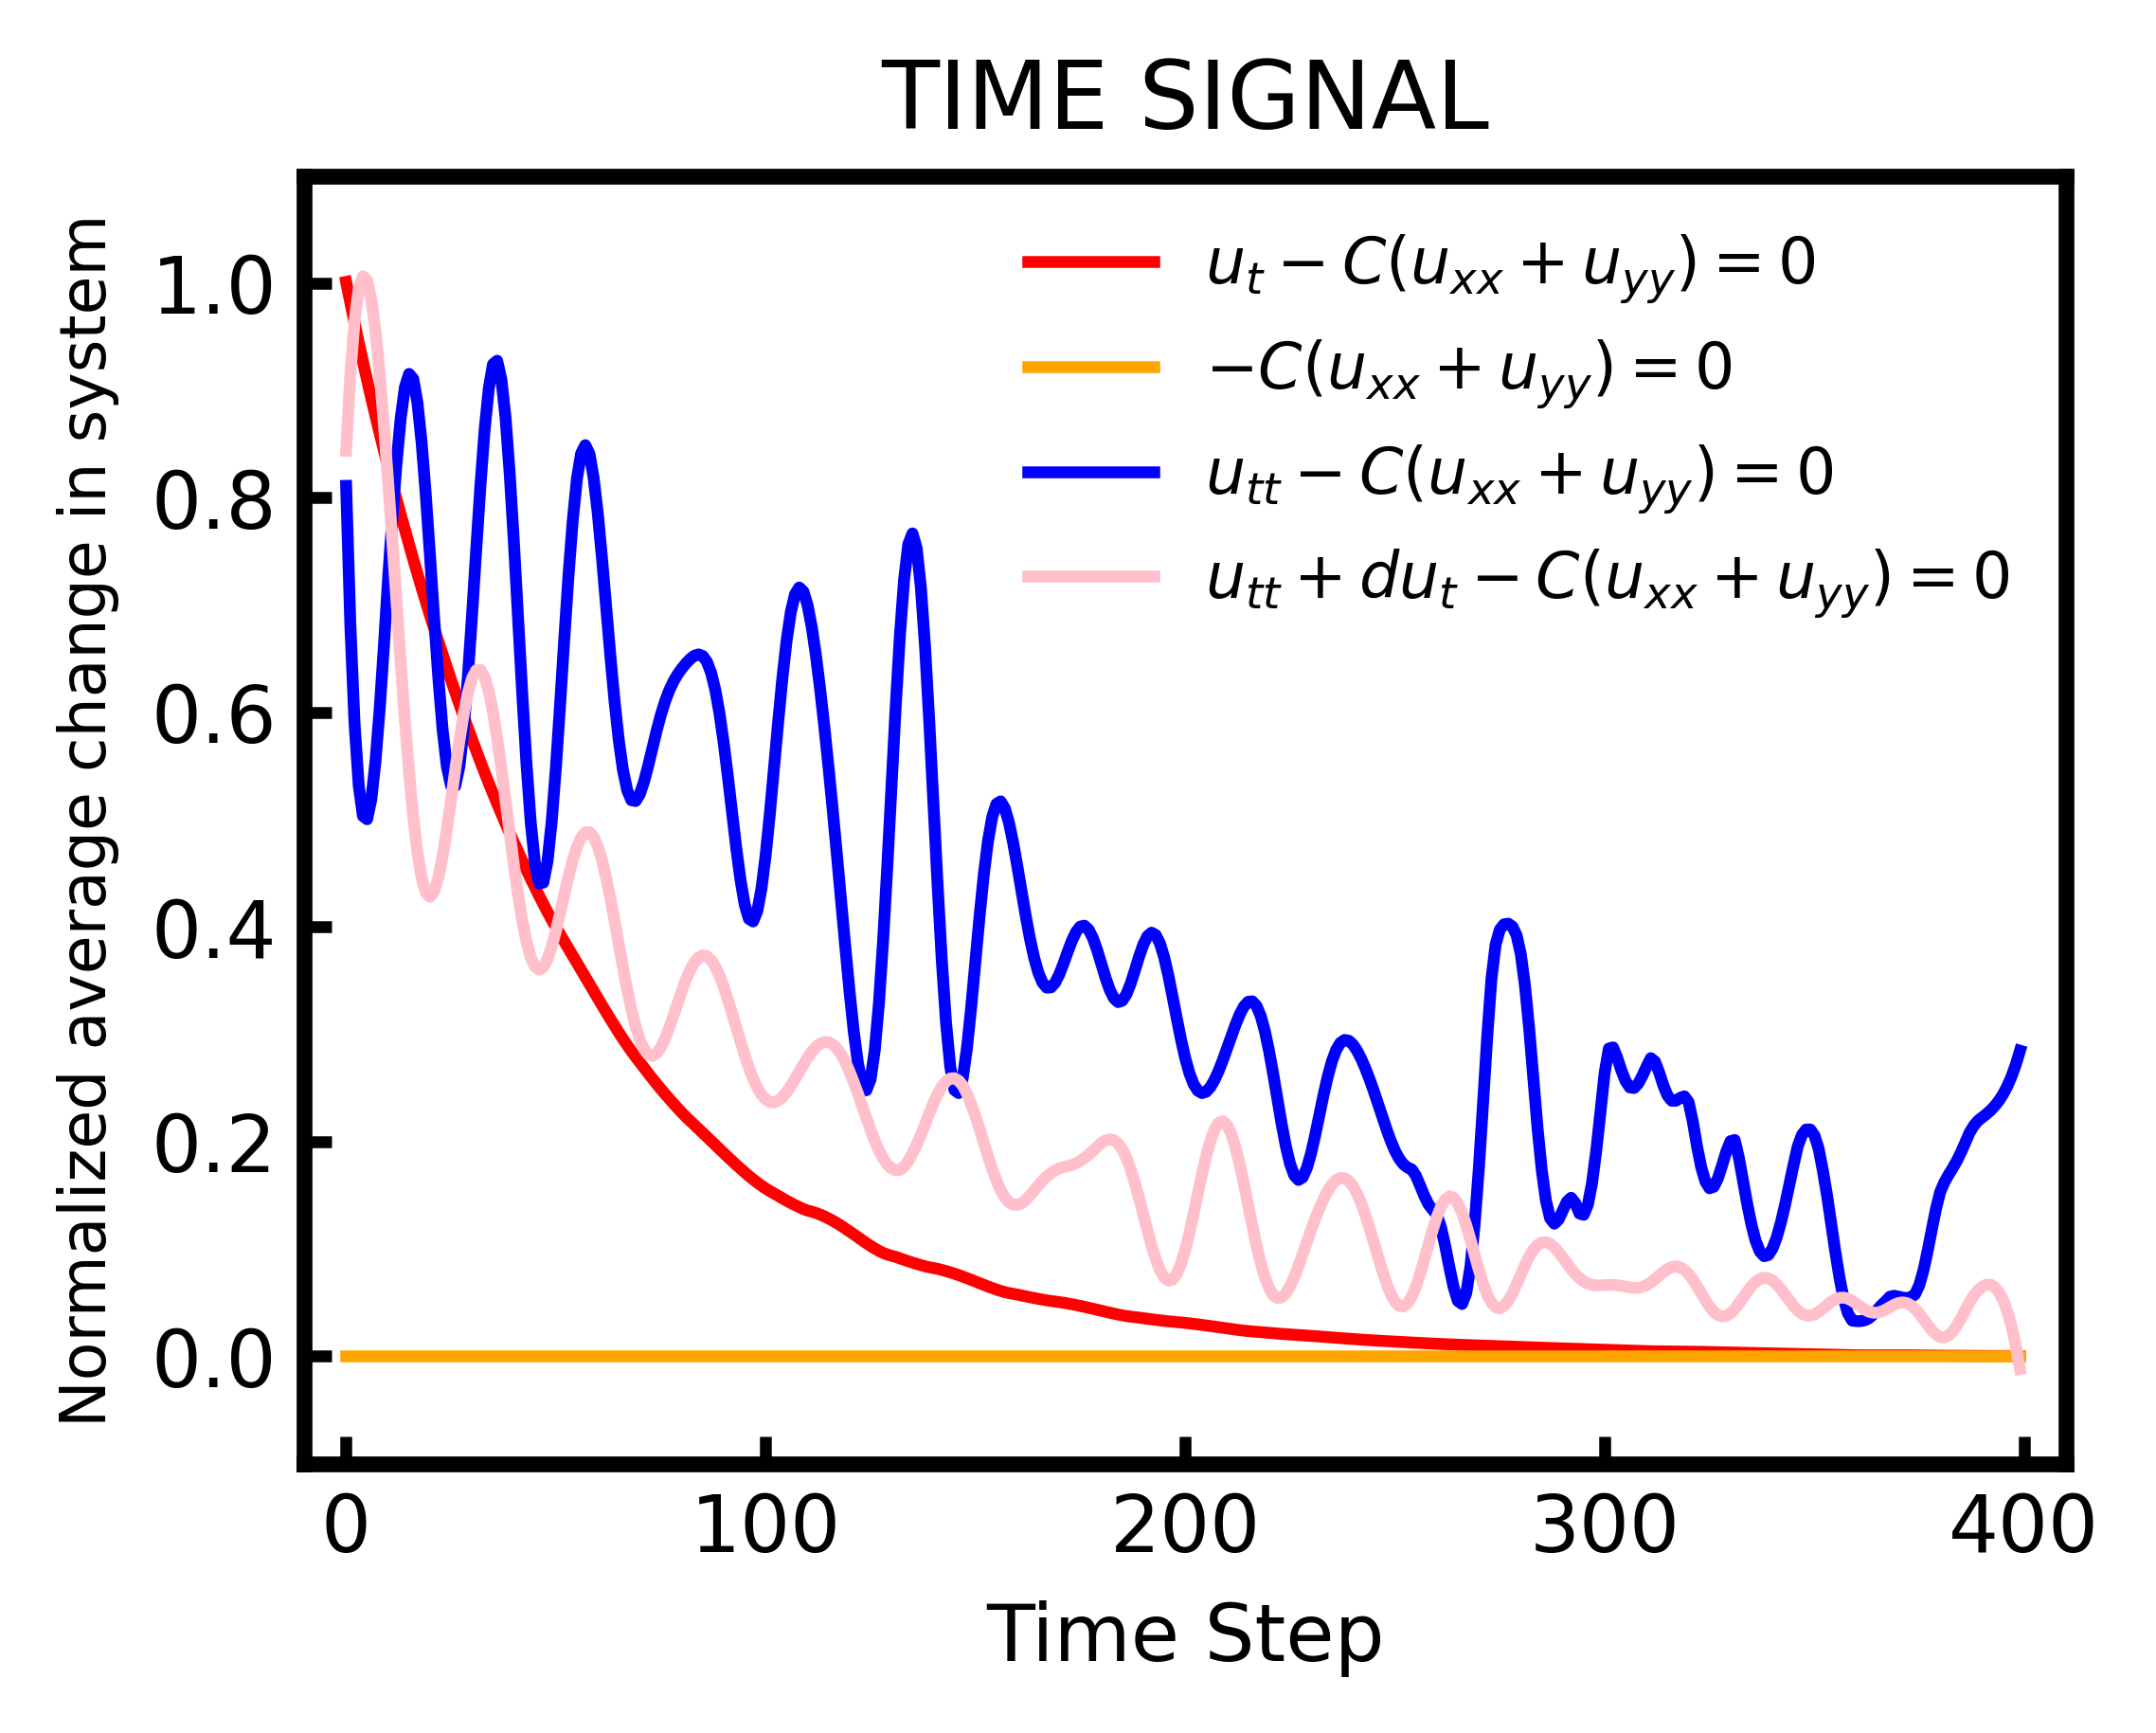

In [64]:
######## Which sample to visualize the time signal for (384 samples for each Equation)
sample = 300

####### SAVITZKY-GOLAY FILTER PARAMETERS:
w = 21
deg = 3
#######

###################### EQUATIONS ################
###### 1) ut - C(uxx + uyy) = 0
###### 2) ut - C(uxx + uyy) + (B_x ux+ B_y uy) = 0
###### 3) - C(uxx + uyy) = 0
###### 4) - C(uxx + uyy) + (B_x ux+ B_y uy) = 0
###### 5) utt - C(uxx + uyy) = 0
###### 6) utt - C(uxx + uyy) + (B_x ux+ B_y uy) = 0
###### 7) utt + d ut - C(uxx + uyy) = 0
###### 8) utt + d ut - C(uxx + uyy) + (B_x ux+ B_y uy) = 0
#################################################

Curves = np.zeros((8,400))

for eq in range(8):
    df = pd.read_csv ('./DATA/'+str(eq+1)+'/' + str(sample) + '.csv' , header=None)
    data = df.to_numpy()
    sequence = process(data)
    temp = sub(sequence)[51:-50]
    temp = np.abs(temp)
    if np.max(temp) == np.min(temp):
        two_mean = temp
    else:
        two_mean = (temp - np.min(temp)) / (np.max(temp) - np.min(temp)) ######## NORMALIZE 
    Curves[eq] = savgol_filter(two_mean, w, deg)

############## PLOT 
fig = plt.figure(figsize = [4,3], dpi = 600)
width = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(width)
    
tick_width = 1.5
plt.tick_params(direction = 'in', width = tick_width)

plt.axis([-10,410,-0.1,1.1])

######## UNCOMMENT EQUATIONS YOU WANT TO VISUALIZE 

plt.plot(Curves[0]  , label = r'$u_t -C(u_{xx}+u_{yy}) = 0$', c='red') 
# plt.plot(Curves[1]  , label = r'$u_t -C(u_{xx}+u_{yy}) + (B_x u_x+ B_y u_y) = 0$', c='maroon') 
plt.plot(Curves[2], label = r'$-C(u_{xx}+u_{yy}) = 0$', c ='orange')
# plt.plot(Curves[3], label = r'$-C(u_{xx}+u_{yy}) + (B_x u_x+ B_y u_y) = 0$', c ='yellow')
plt.plot(Curves[4], label = r'$u_{tt} -C(u_{xx}+u_{yy}) = 0$', c ='blue')
# plt.plot(Curves[5], label = r'$u_{tt} -C(u_{xx}+u_{yy}) + (B_x u_x+ B_y u_y) = 0$', c ='navy')
plt.plot(Curves[6], label = r'$u_{tt} + d u_t - C(u_{xx}+u_{yy}) = 0$', c ='pink')
# plt.plot(Curves[7], label = r'$u_{tt} + d u_t - C(u_{xx}+u_{yy}) + (B_x u_x+ B_y u_y) = 0$', c ='purple')

plt.legend(bbox_to_anchor=(1,1), fontsize = 8, frameon = False) #loc='upper right',
plt.title("TIME SIGNAL")
plt.ylabel("Normalized average change in system", fontsize=8)
plt.xlabel("Time Step", fontsize=10)
plt.show()

 # 1-1)  Signal Statistics : Extract and save (mean,min,max,std, skew)

In [65]:
######## DATA SIZE: 384 equations for 8 PDEs
Curves = np.zeros((8*384,400))
for eq in range(8): 
    for iter in range(384):
        df = pd.read_csv ('./DATA/'+str(eq+1)+'/' + str(iter+1) + '.csv' , header=None)
        data = df.to_numpy()
        sequence = process(data)
        temp = sub(sequence)[51:-50]
        temp = np.abs(temp)
        if np.max(temp) == np.min(temp):
            two_mean = temp
        else:
            two_mean = (temp - np.min(temp)) / (np.max(temp) - np.min(temp)) ######## NORMALIZE 
        Curves[eq*384 + iter] = two_mean

###### RAW SIGNALS 
# np.save('./FEATURES/Time_signal.npy',Curves)
print("TIME SIGNAL FEATURE SHAPE: ",Curves.shape)
## Normalized Vectors
mean_t = np.mean(Curves, axis=1).reshape(-1,1)
std_t = np.std(Curves, axis=1).reshape(-1,1)
min_l = np.min(Curves[:,350:] , axis=1).reshape(-1,1)
max_l = np.max(Curves[:,350:] , axis=1).reshape(-1,1)
mean_l = np.mean(Curves[:,350:] , axis=1).reshape(-1,1)
std_l = np.std(Curves[:,350:] , axis=1).reshape(-1,1)
skew_t = skew(Curves, axis=1).reshape(-1,1)

data_features = np.concatenate((mean_t,std_t,
                                min_l,max_l,mean_l,std_l,
                                skew_t) , axis = 1)

print(data_features.shape)
# np.save('./FEATURES/Time_signal_stats.npy',data_features)

TIME SIGNAL FEATURE SHAPE:  (3072, 400)
(3072, 7)


 # 1-2) FFT of Time Signal Visualization

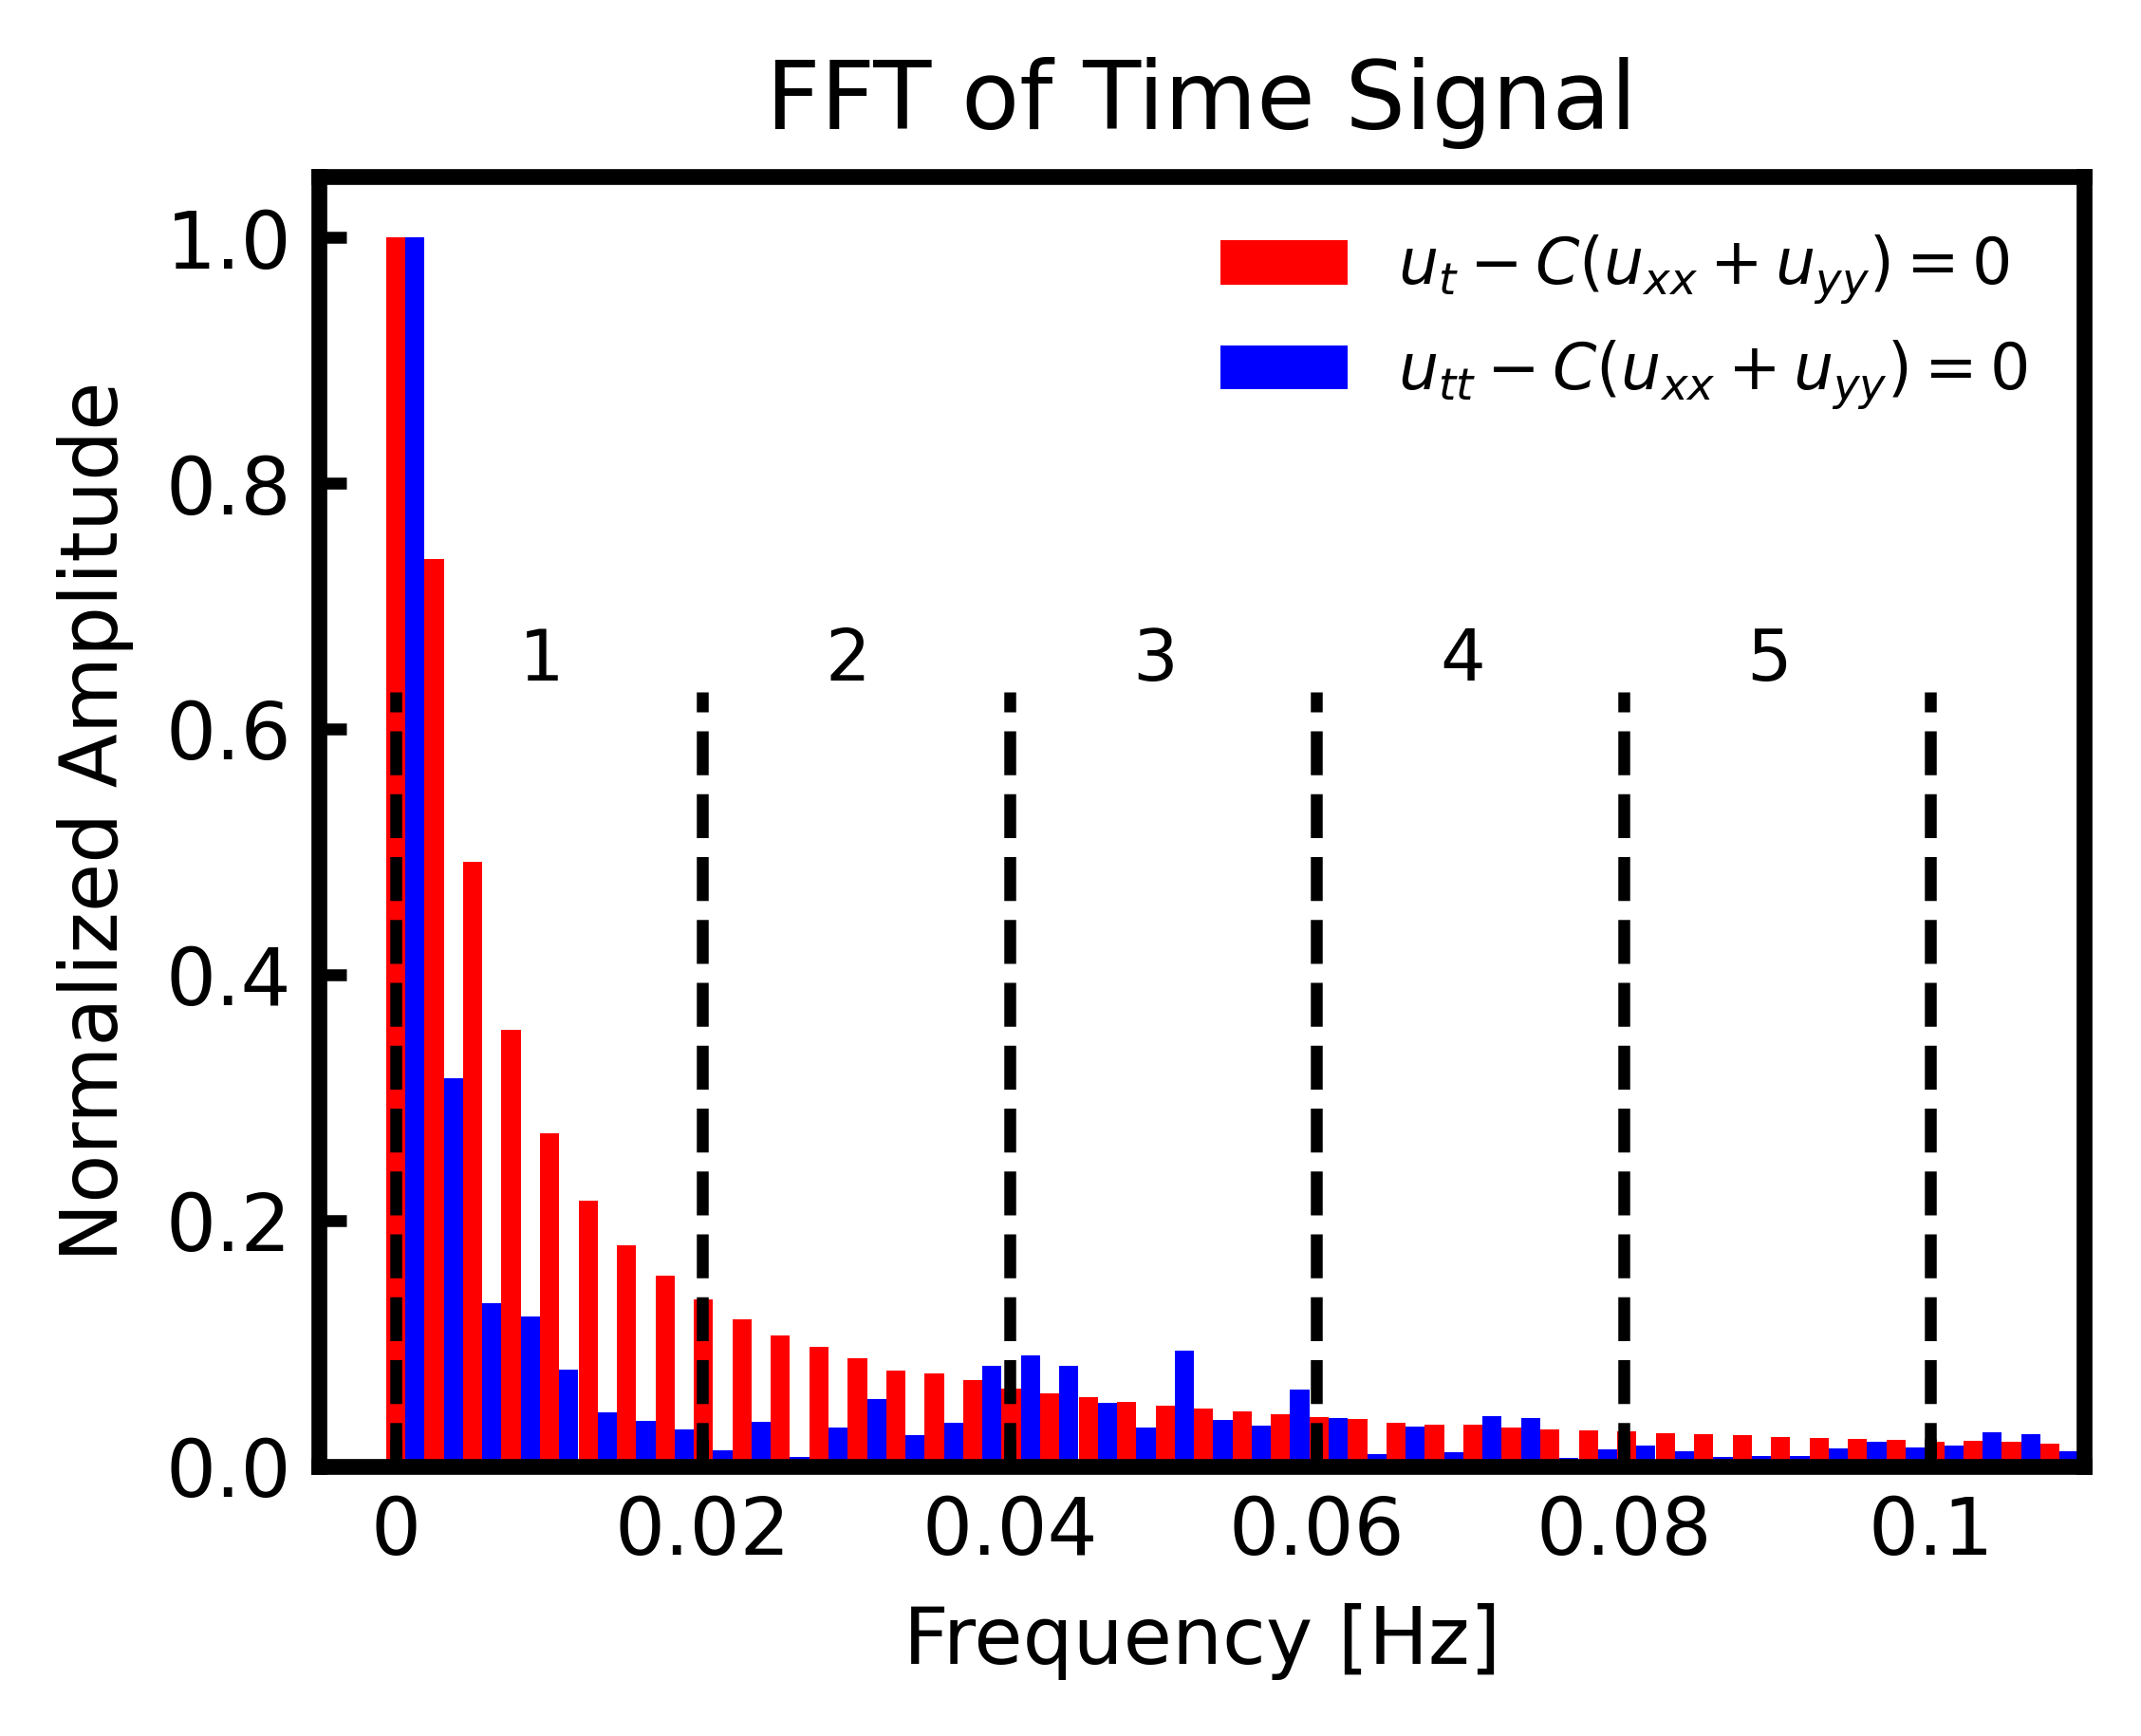

In [68]:
t = np.arange(400)
T = t[1] - t[0]  
N = 400    
# 1/T = frequency
f = np.linspace(0, 1 / T, N)

sample = 300
FFT_Curves = np.zeros((8,200))
for eq in range(8):
    df = pd.read_csv ('./DATA/'+str(eq+1)+'/' + str(sample) + '.csv' , header=None)
    data = df.to_numpy()
    sequence = process(data)
    temp = sub(sequence)[51:-50]
    temp = np.abs(temp)
    if np.max(temp) == np.min(temp):
        two_mean = temp
    else:
        two_mean = (temp - np.min(temp)) / (np.max(temp) - np.min(temp)) ######## NORMALIZE 
    fft_two_mean = np.fft.fft(two_mean)
    fft_two_mean = np.abs(fft_two_mean)[:N // 2] * 1 / N
    fft_two_mean = (fft_two_mean - np.min(fft_two_mean))/(np.max(fft_two_mean)-np.min(fft_two_mean))
    FFT_Curves[eq] = fft_two_mean
    
## PLOT
fig = plt.figure(figsize = [4,3], dpi = 600)
width = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(width)
    
tick_width = 1.5
plt.tick_params(direction = 'in', width = tick_width)

plt.axis([-0.005,0.11,0,1.05])
plt.xticks([0, 0.02, 0.04,0.06, 0.08, 0.1],['0', '0.02','0.04','0.06','0.08', '0.1'],
           fontsize = 10)
plt.yticks(fontsize = 10)

f = np.linspace(0, 1 / T, N)
plt.bar(f[:N // 2], FFT_Curves[0], width=0.00125, label=r'$u_t -C(u_{xx}+u_{yy}) = 0$' ,color='red')
# plt.bar(f[:N // 2], FFT_Curves[1], width=0.00125, label=r'$u_t -C(u_{xx}+u_{yy}) + (B_x u_x+ B_y u_y) = 0$',color='maroon')
# plt.bar(f[:N // 2], FFT_Curves[2], width=0.00125, label=r'$-C(u_{xx}+u_{yy}) = 0$' ,color='orange')
# plt.bar(f[:N // 2], FFT_Curves[3], width=0.00125, label=r'$-C(u_{xx}+u_{yy}) + (B_x u_x+ B_y u_y) = 0$' ,color='yellow')
plt.bar(f[:N // 2]+0.00125, FFT_Curves[4], width=0.00125, label=r'$u_{tt} -C(u_{xx}+u_{yy}) = 0$' ,color='blue')
# plt.bar(f[:N // 2], FFT_Curves[5], width=0.00125, label=r'$u_{tt} -C(u_{xx}+u_{yy}) + (B_x u_x+ B_y u_y) = 0$' ,color='navy')
# plt.bar(f[:N // 2], FFT_Curves[6], width=0.00125, label=r'$u_{tt} + d u_t - C(u_{xx}+u_{yy}) = 0$' ,color='pink')
# plt.bar(f[:N // 2], FFT_Curves[7], width=0.00125, label=r'$u_{tt} + d u_t - C(u_{xx}+u_{yy}) + (B_x u_x+ B_y u_y) = 0$' ,color='purple')

ax.vlines([0,0.02, 0.04,0.06, 0.08,0.1], 0, 0.6,  
          color ="black", linestyle='dashed',
          transform = ax.get_xaxis_transform()) 
for i in range(5):
    ax.text(0.02*i+0.008, 0.64 , str(i+1), color='black', fontsize=9)

plt.ylabel("Normalized Amplitude")
plt.xlabel("Frequency [Hz]")
plt.title("FFT of Time Signal")
plt.legend(bbox_to_anchor=(1,1), fontsize = 8, frameon = False)
plt.show()

 # 1-3) FFT Save feature

In [69]:
t = np.arange(400)
T = t[1] - t[0]  
N = 400    #t_x_two_mean.size
# 1/T = frequency
f = np.linspace(0, 1 / T, N)

FFT_MIN = np.zeros((8*384,5))
FFT_MEAN = np.zeros((8*384,5))
FFT_MAX = np.zeros((8*384,5))
FFT_STD = np.zeros((8*384,5))

for eq in tqdm(range(8)):
    for iter in range(384):
        df = pd.read_csv ('./DATA/'+str(eq+1)+'/' + str(iter+1) + '.csv' , header=None)
        data = df.to_numpy()
        sequence = process(data)
        temp = sub(sequence)[51:-50]
        if np.max(temp) == np.min(temp):
            two_mean = temp
        else:
            two_mean = (temp - np.min(temp)) / (np.max(temp) - np.min(temp)) ######## NORMALIZE 
        fft_two_mean = np.fft.fft(two_mean)
        if np.max(fft_two_mean) != np.min(fft_two_mean):  
            fft_two_mean = np.abs(fft_two_mean)[:N // 2] * 1 / N
            fft_two_mean = (fft_two_mean - np.min(fft_two_mean))/(np.max(fft_two_mean)-np.min(fft_two_mean))
        for b in range(5):
            FFT_MIN[eq*384+iter, b] = np.min(np.abs(fft_two_mean[b*N//50:(b+1)*N//50] * 1/N))
            FFT_MEAN[eq*384+iter, b] = np.mean(np.abs(fft_two_mean[b*N//50:(b+1)*N//50] * 1/N))
            FFT_MAX[eq*384+iter, b] = np.max(np.abs(fft_two_mean[b*N//50:(b+1)*N//50] * 1/N))
            FFT_STD[eq*384+iter, b] = np.std(np.abs(fft_two_mean[b*N//50:(b+1)*N//50] * 1/N))

print("check shape: " , FFT_MIN.shape)
# np.save('./FEATURES/FFT_MIN.npy', FFT_MIN)
# np.save('./FEATURES/FFT_MEAN.npy', FFT_MEAN)
# np.save('./FEATURES/FFT_MAX.npy', FFT_MAX)
# np.save('./FEATURES/FFT_STD.npy', FFT_STD)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [01:07<07:55, 67.98s/it]

 25%|██▌       | 2/8 [02:16<06:49, 68.18s/it]

 38%|███▊      | 3/8 [02:19<04:02, 48.53s/it]

 50%|█████     | 4/8 [02:21<02:18, 34.60s/it]

 62%|██████▎   | 5/8 [03:29<02:14, 44.76s/it]

 75%|███████▌  | 6/8 [04:37<01:43, 51.62s/it]

 88%|████████▊ | 7/8 [05:44<00:56, 56.35s/it]

100%|██████████| 8/8 [06:52<00:00, 51.51s/it]

check shape:  (3072, 5)


 # Motion feature 

In [61]:
def motion_process (sequence):
    mean_arg_list = []
    filter_size = 3
    half_filter = (filter_size - 1)//2

    for frame in range(5,495,5):
        mat = sequence[frame]
        next_mat = sequence[frame +1]
        arg_indices = []
        for i in range(half_filter+1 ,len(sequence[frame])- half_filter-1):
            for j in range(half_filter+1,len(sequence[frame])- half_filter-1):
                filter = np.zeros((filter_size, filter_size))
                current_point = mat[i,j]
                filter = next_mat[  i-half_filter : i+half_filter+1    ,   j-half_filter : j+half_filter+1 ]
                filter_copy = copy.copy(filter)
                filter_copy[half_filter,half_filter] = 10 
                arg = np.argmin(np.abs(filter_copy - current_point))
                arg_index = np.unravel_index(arg, filter.shape) - np.array([half_filter,half_filter])
                arg_indices.append(arg_index)
        mean_arg = np.mean(arg_indices , axis = 0)
        mean_arg_list.append(mean_arg)
    mean_total = np.mean(mean_arg_list , axis = 0)
    return mean_total

Motion = np.zeros(8*384)
for eq in tqdm(range(8)):
    for iter in range(384):
        df = pd.read_csv ('./DATA/'+str(eq+1)+'/' + str(iter+1) + '.csv' , header=None)
        data = df.to_numpy()
        sequence = process(data)
        Motion[eq*384+iter] = np.sqrt(np.sum(np.power(motion_process(sequence),2) ))

# np.save('./FEATURES/MOTION.npy', Motion)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [03:06<21:48, 186.96s/it]

 25%|██▌       | 2/8 [06:12<18:39, 186.65s/it]

 38%|███▊      | 3/8 [08:14<13:55, 167.07s/it]

 50%|█████     | 4/8 [10:15<10:13, 153.31s/it]

 62%|██████▎   | 5/8 [13:21<08:09, 163.26s/it]

 75%|███████▌  | 6/8 [16:30<05:41, 170.75s/it]

 88%|████████▊ | 7/8 [19:37<02:55, 175.70s/it]

100%|██████████| 8/8 [22:43<00:00, 170.42s/it]


 # 1-4) Amplitude of Time Signal

# Visualization

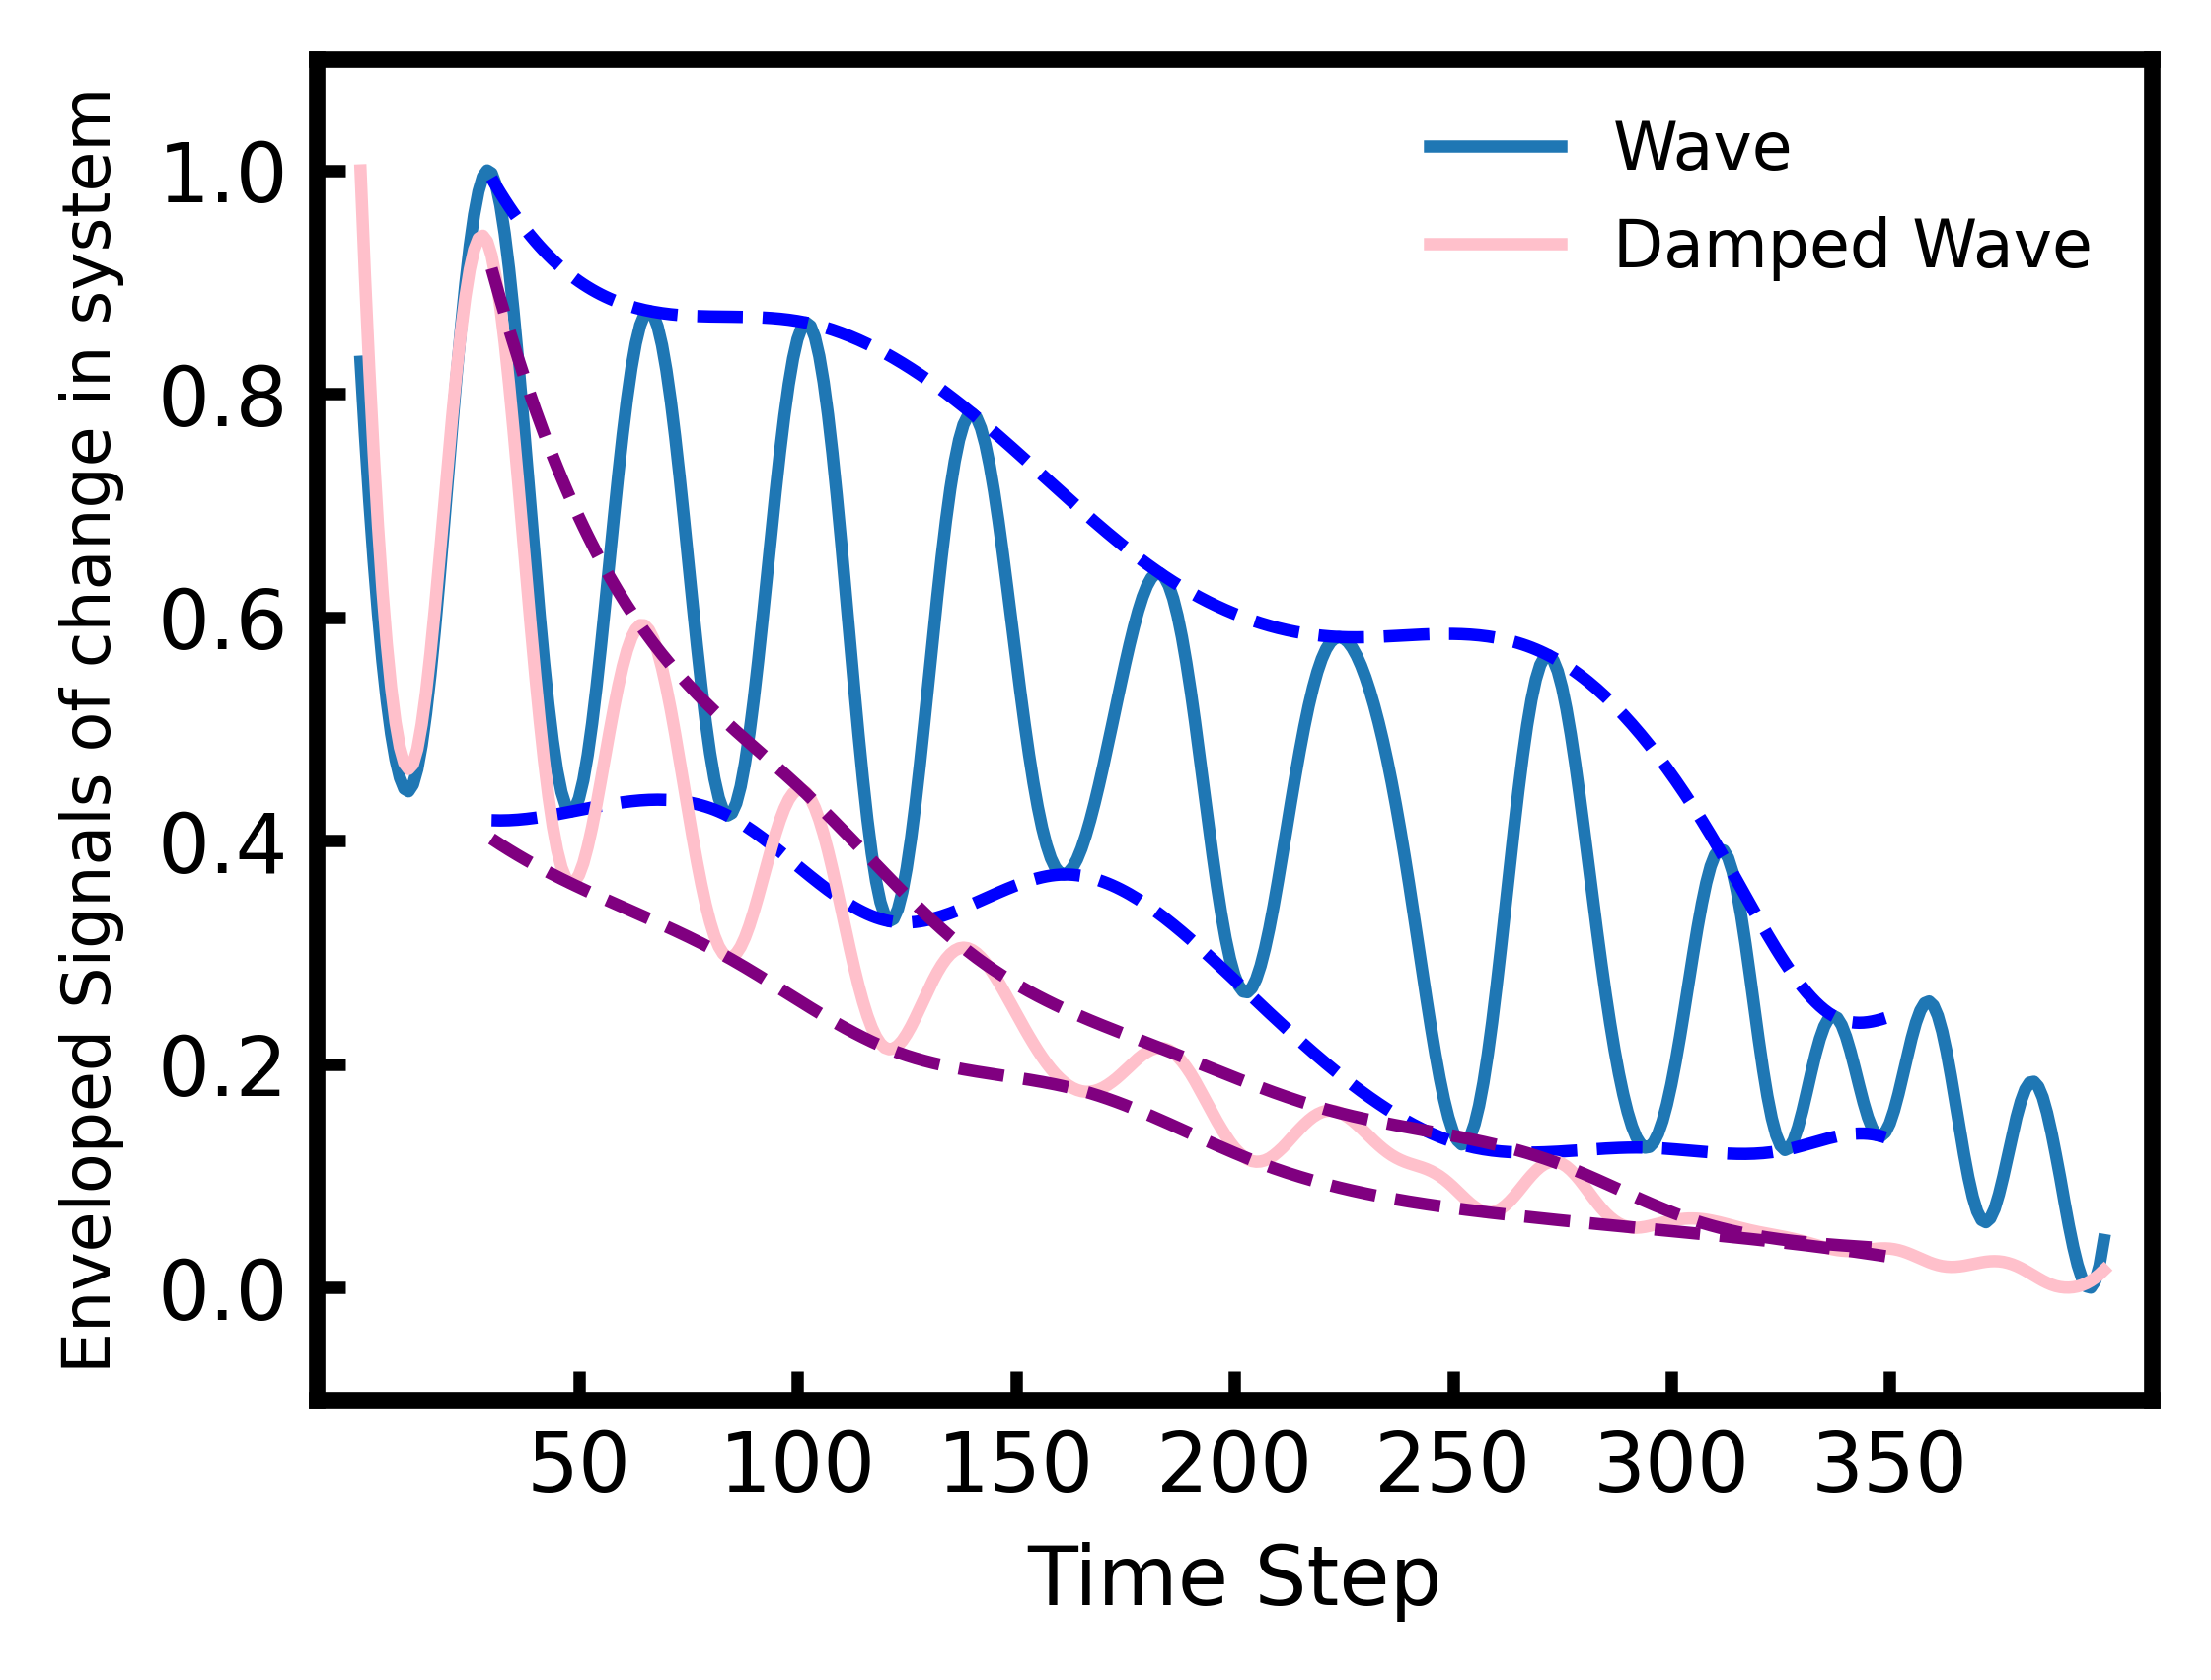

In [70]:
def amplitude(signal):
    t = np.arange(len(signal))
    s = signal
    u_x = []
    u_y = []
    l_x = []
    l_y = []
    count_u = 0
    count_l = 0
    check_first_u = 0
    check_first_l = 0
    for k in range(1,len(s)-1):
        if (np.sign(s[k]-s[k-1])==1) and (np.sign(s[k]-s[k+1])==1):
            u_x.append(k)
            u_y.append(s[k])
            last_s_u = s[k]
            last_x_u = k
            count_u += 1
            if check_first_u == 0:
                first_s_u = s[k]
                first_x_u = k
                check_first_u = 1
        if (np.sign(s[k]-s[k-1])==-1) and ((np.sign(s[k]-s[k+1]))==-1):
            l_x.append(k)
            l_y.append(s[k])
            last_s_l = s[k]
            last_x_l = k
            count_l += 1
            if check_first_l == 0:
                first_s_l = s[k]
                first_x_l = k
                check_first_l = 1
    amp = np.zeros(s.shape)
    if (count_u > 3) and (count_l > 3):
        u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
        l_p = interp1d(l_x,l_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
        q_u = np.zeros(s.shape)
        q_l = np.zeros(s.shape)
        for k in range(0,len(s)):
            q_u[k] = u_p(k)
            q_l[k] = l_p(k)
            amp[k] = q_u[k] - q_l[k]
    return q_u , q_l , amp

################## PARAMETERS
sample = 30
w= 21
deg = 3
##################

df = pd.read_csv ('DATA/5/' + str(sample) + '.csv' , header=None)
data = df.to_numpy()
sequence = process(data)
temp = sub(sequence)[50:450]
temp = np.abs(temp)
temp = savgol_filter(temp, w, deg)
two_mean = (temp - np.min(temp)) / (np.max(temp) - np.min(temp))   
signal_wave = two_mean
up_env_wave , low_env_wave , amp_wave = amplitude(signal_wave)
    
df = pd.read_csv ('DATA/7/' + str(sample) + '.csv' , header=None)
data = df.to_numpy()
sequence = process(data)
temp = sub(sequence)[50:450]
temp = np.abs(temp)
temp = savgol_filter(temp, w, deg)
two_mean = (temp - np.min(temp)) / (np.max(temp) - np.min(temp))   
signal_b = two_mean
up_env_b , low_env_b , amp_b = amplitude(signal_b)

#### PLOT 
fig = plt.figure(figsize = [4,3], dpi = 600)
width = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(width)
tick_width = 1.5
plt.tick_params(direction = 'in', width = tick_width)
plt.axis([-10,410,-0.1,1.1])
plt.xticks([50, 100, 150,200, 250,300,350],['50', '100','150','200','250','300','350'],
           fontsize = 10)
plt.yticks(fontsize = 10)

plt.plot(t, signal_wave,color='C0',label='Wave')
plt.plot(t[30:350],up_env_wave[30:350], 'blue',linestyle='dashed')
plt.plot(t[30:350], low_env_wave[30:350], 'blue',linestyle='dashed')
plt.plot(t, signal_b,color='pink', label='Damped Wave')
plt.plot(t[30:350], up_env_b[30:350], 'purple',linestyle='dashed')
plt.plot(t[30:350], low_env_b[30:350], 'purple',linestyle='dashed')

plt.legend(loc='upper right', fontsize = 8, frameon = False)
plt.ylabel("Enveloped Signals of change in system", fontsize=8)
plt.xlabel("Time Step", fontsize=10)
plt.show()

# Amplitude of Time Signal Extract and Save data

In [71]:
def amplitude(signal):
    t = np.arange(len(signal))
    s = signal
    u_x = []
    u_y = []
    l_x = []
    l_y = []
    count_u = 0
    count_l = 0
    check_first_u = 0
    check_first_l = 0
    for k in range(1,len(s)-1):
        if (np.sign(s[k]-s[k-1])==1) and (np.sign(s[k]-s[k+1])==1):
            u_x.append(k)
            u_y.append(s[k])
            last_s_u = s[k]
            last_x_u = k
            count_u += 1
            if check_first_u == 0:
                first_s_u = s[k]
                first_x_u = k
                check_first_u = 1
        if (np.sign(s[k]-s[k-1])==-1) and ((np.sign(s[k]-s[k+1]))==-1):
            l_x.append(k)
            l_y.append(s[k])
            last_s_l = s[k]
            last_x_l = k
            count_l += 1
            if check_first_l == 0:
                first_s_l = s[k]
                first_x_l = k
                check_first_l = 1
    amp = np.zeros(s.shape)
    a_max = 0
    a_argmax = 0
    a_mean = 0
    a_std =0
    a_skew = 0
    a_lastmean = 0
    a_laststd = 0
    a_ratio = 0 
    a_ratio_max =0
    ################### OSCILLATION CONDITION
    if (count_u > 3) and (count_l > 3):
        u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
        l_p = interp1d(l_x,l_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
        q_u = np.zeros(s.shape)
        q_l = np.zeros(s.shape)
        for k in range(0,len(s)):
            q_u[k] = u_p(k)
            q_l[k] = l_p(k)
            amp[k] = q_u[k] - q_l[k]
        amp = np.abs(amp)
        half = len(amp)//2
        a_max = np.max(amp)
        a_argmax = np.argmax(amp)
        a_mean = np.mean(amp)
        a_std = np.std(amp)
        a_skew = skew(amp)
        last_x = min(last_x_l , last_x_u)
        first_x = max(first_x_l , first_x_u)
        if (first_x < half) and (last_x > half):
            a_lastmean = np.mean(amp[half:last_x])
            a_laststd = np.std(amp[half:last_x])
            if np.mean(amp[first_x:half]) > (0.01 * np.mean(amp[half:last_x])):
                a_ratio = np.mean(amp[half:last_x]) / np.mean(amp[first_x:half])

            if np.max(amp[first_x:half]) > (0.01 * np.max(amp[half:last_x])):
                a_ratio_max = np.max(amp[half:last_x]) / np.max(amp[first_x:half])
    return a_max, a_argmax, a_mean, a_std, a_skew, a_lastmean, a_laststd, count_u , count_l , a_ratio, a_ratio_max

AMPLITUDE = np.zeros((8*384, 11))
for eq in tqdm(range(8)):
    for iter in range(384):
        df = pd.read_csv ('./DATA/'+str(eq+1)+'/' + str(iter+1) + '.csv' , header=None)
        data = df.to_numpy()
        sequence = process(data)
        temp = sub(sequence)[51:-50]
        temp = np.abs(temp)
        if np.max(temp) == np.min(temp):
            two_mean = temp
        else:
            two_mean = (temp - np.min(temp)) / (np.max(temp) - np.min(temp)) ######## NORMALIZE 
        two_mean = savgol_filter(two_mean, w, deg)  
        signal = two_mean
        AMPLITUDE[384*eq + iter] = amplitude(signal)

# np.save('FEATURES/AMPLITUDE.npy', AMPLITUDE)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [01:10<08:15, 70.72s/it]

 25%|██▌       | 2/8 [02:26<07:12, 72.15s/it]

 38%|███▊      | 3/8 [02:28<04:16, 51.25s/it]

 50%|█████     | 4/8 [02:31<02:26, 36.62s/it]

 62%|██████▎   | 5/8 [03:47<02:25, 48.50s/it]

 75%|███████▌  | 6/8 [05:03<01:53, 56.67s/it]

 88%|████████▊ | 7/8 [06:18<01:02, 62.35s/it]

100%|██████████| 8/8 [07:34<00:00, 56.77s/it]


 # 2) Space - Motion direction (Symmetry)

 # Visualization 

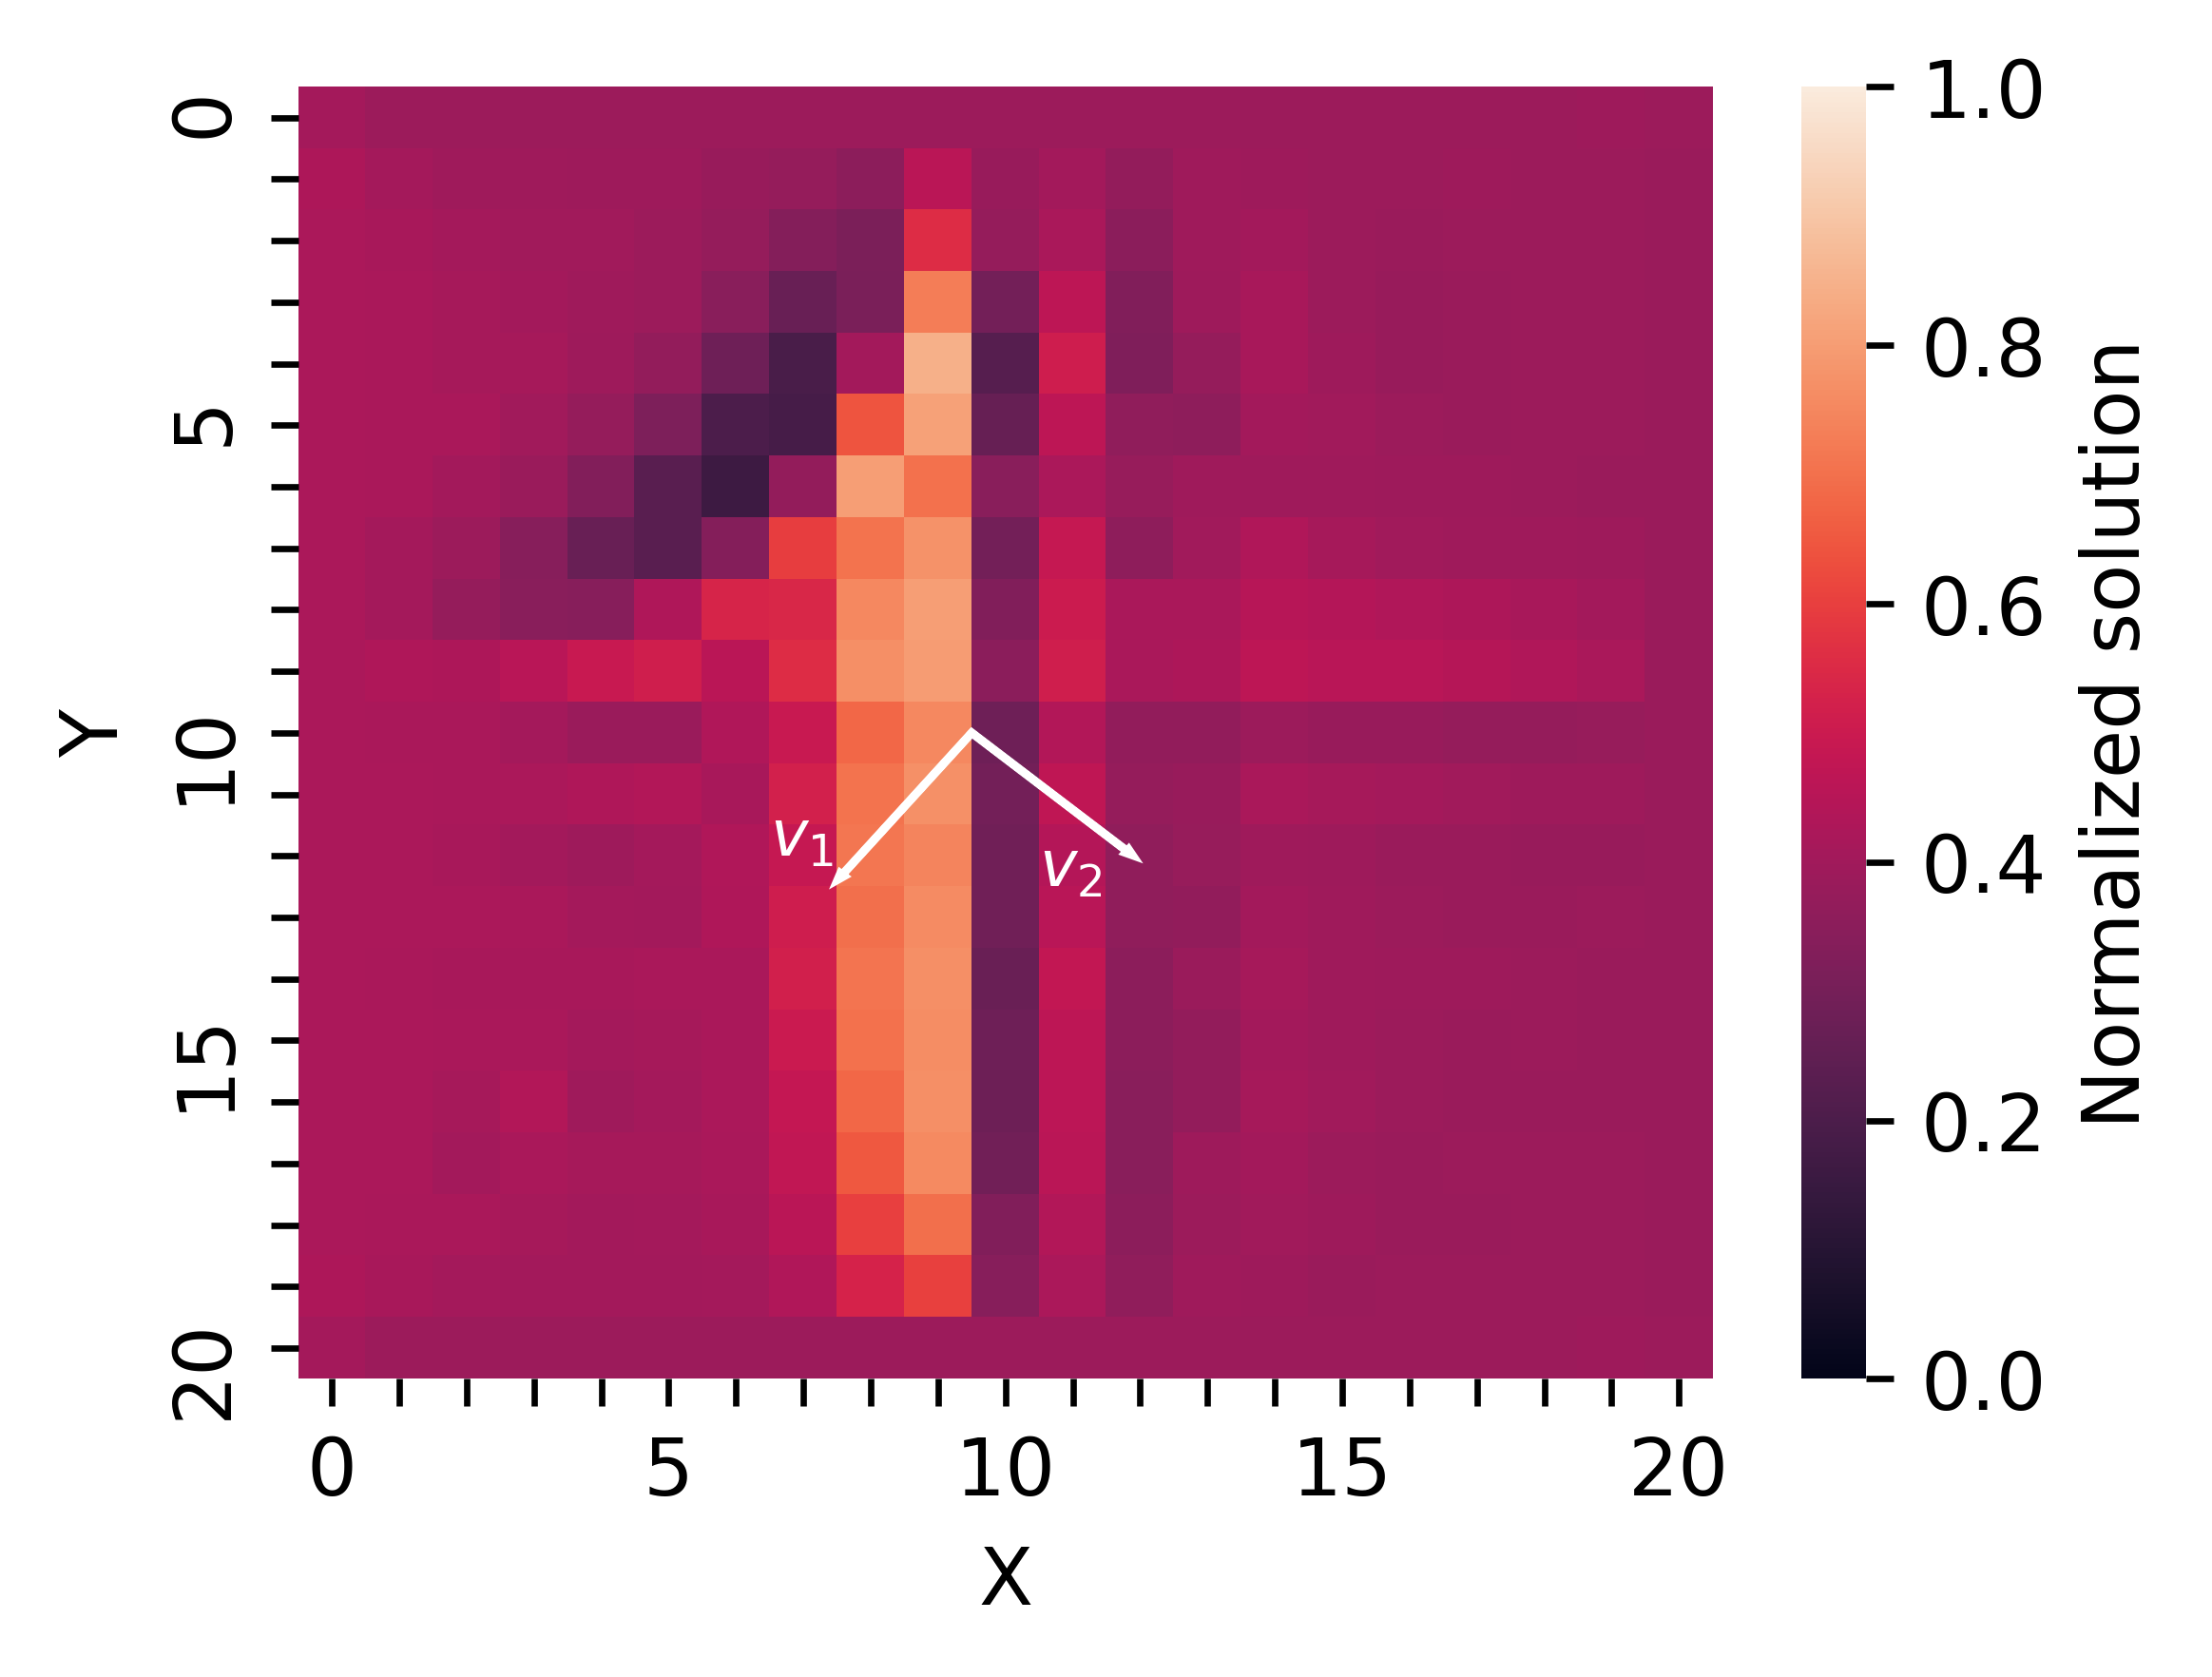

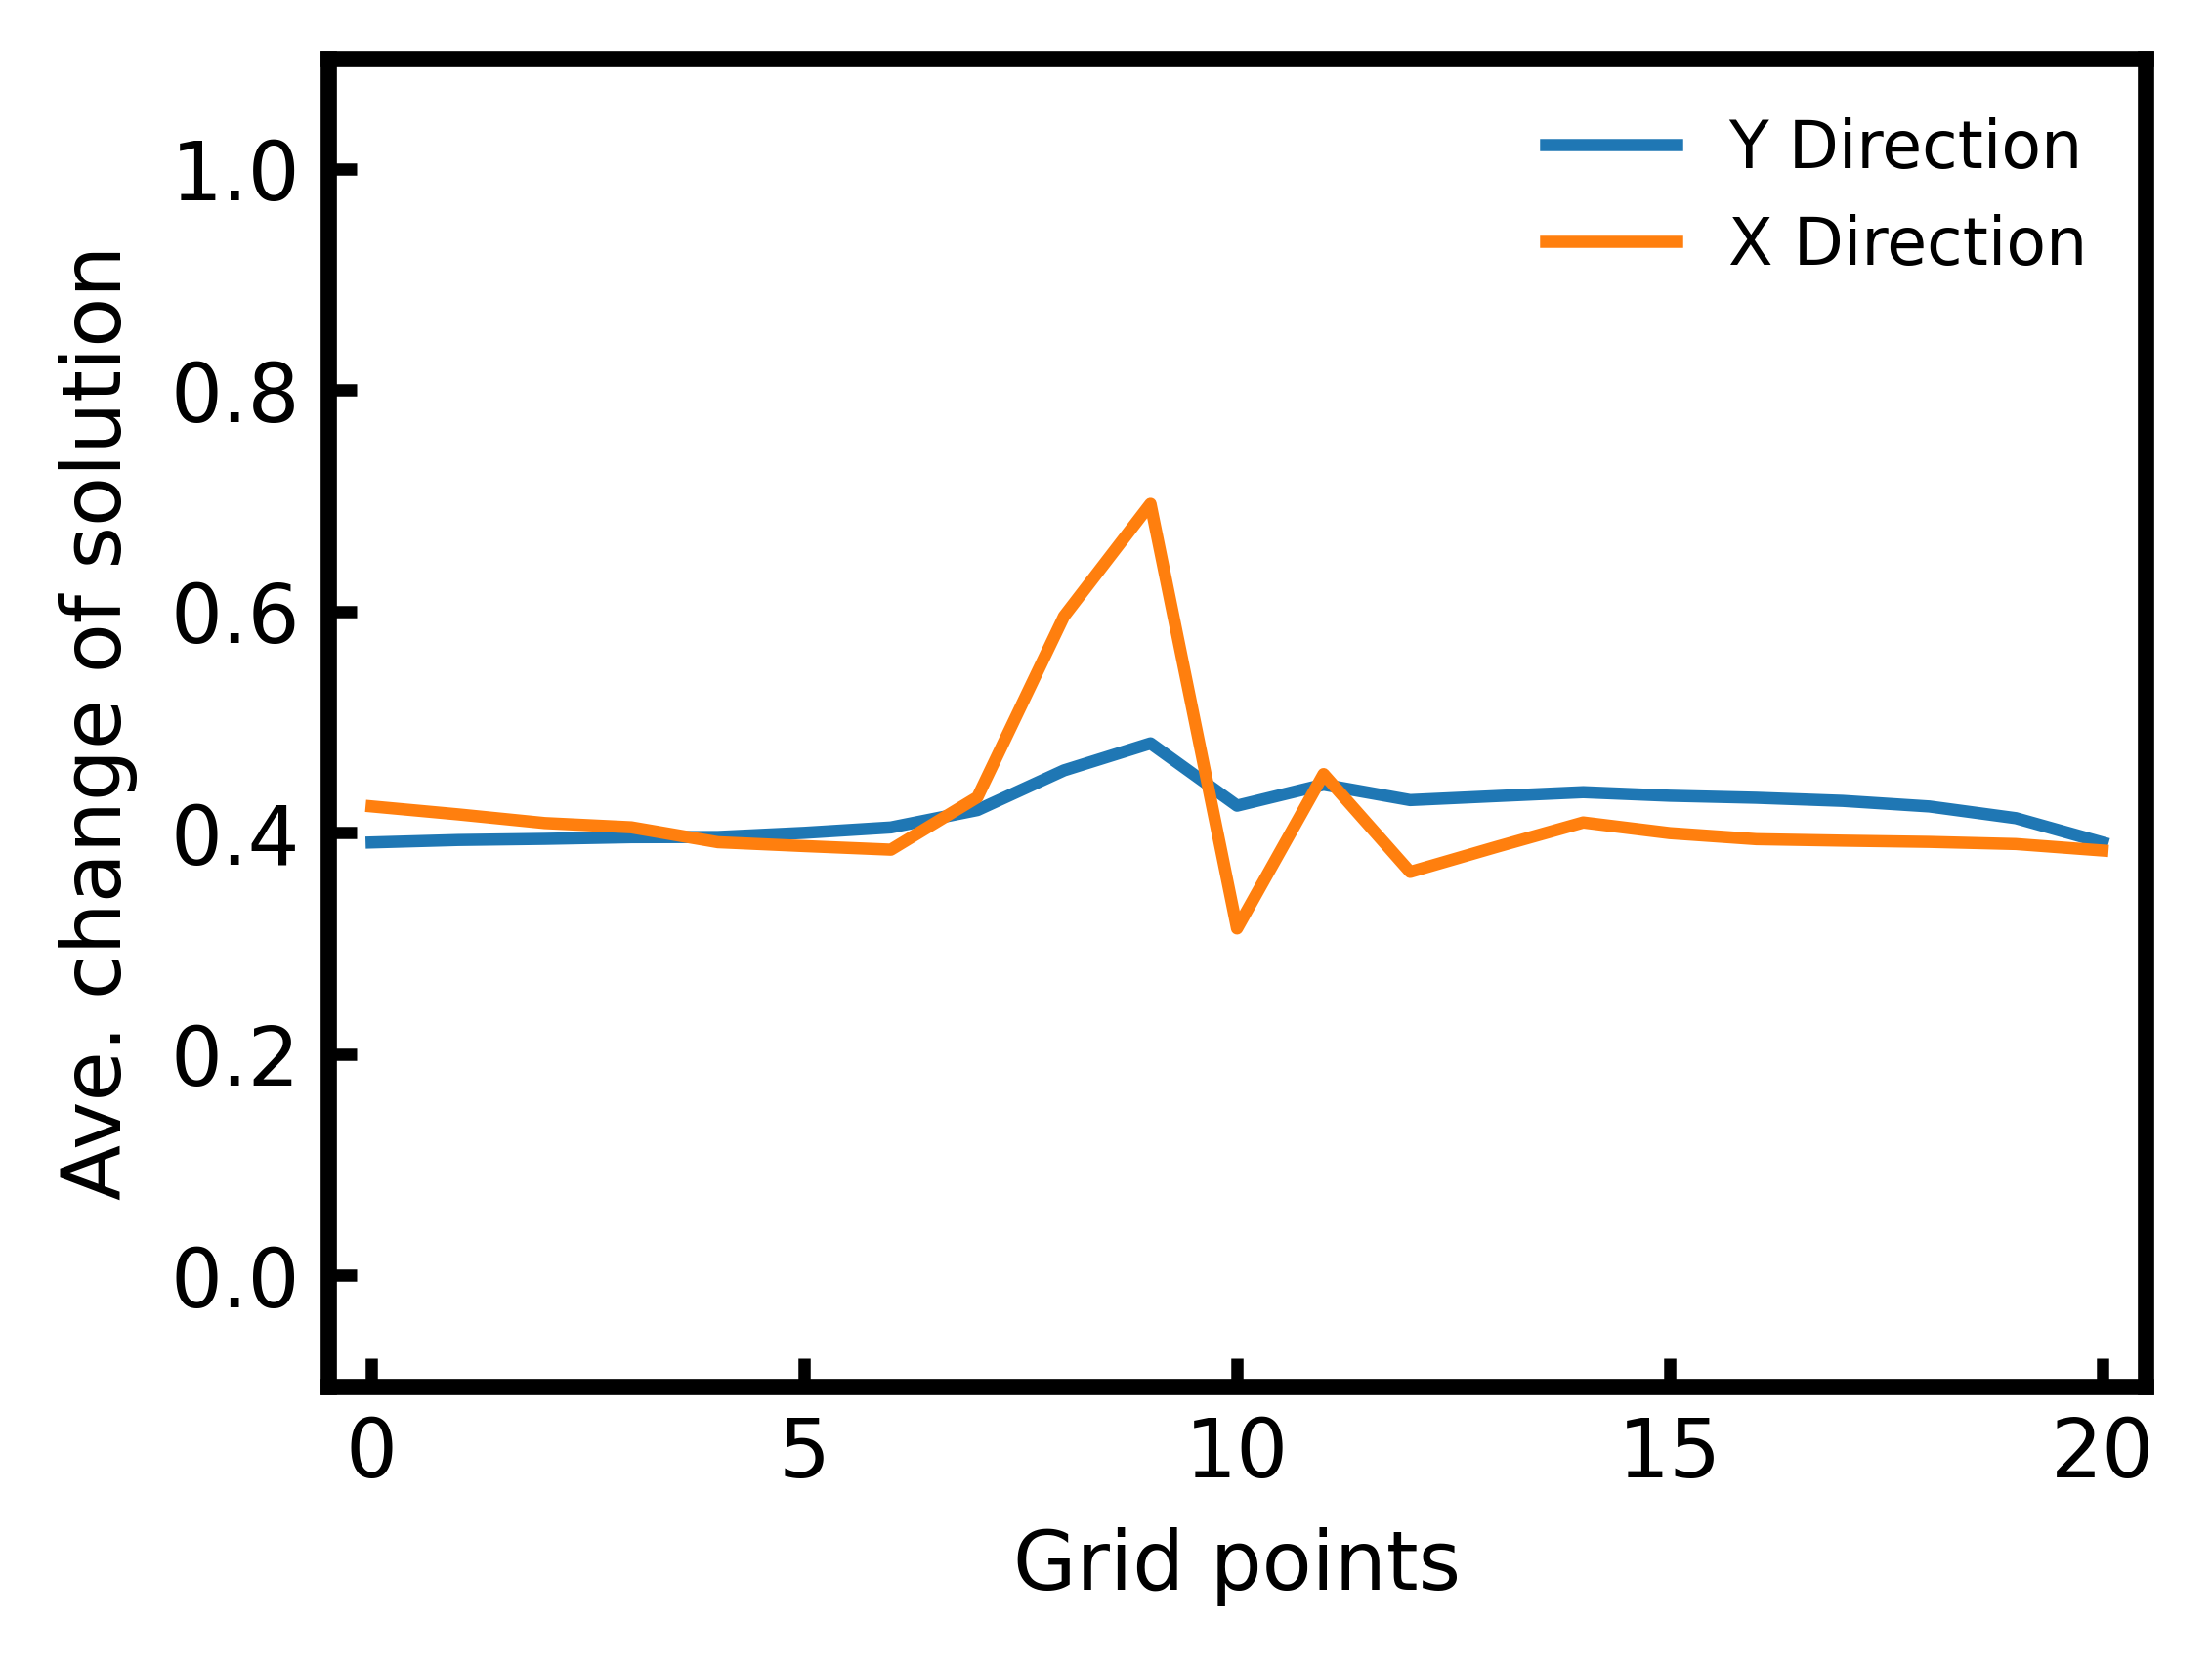

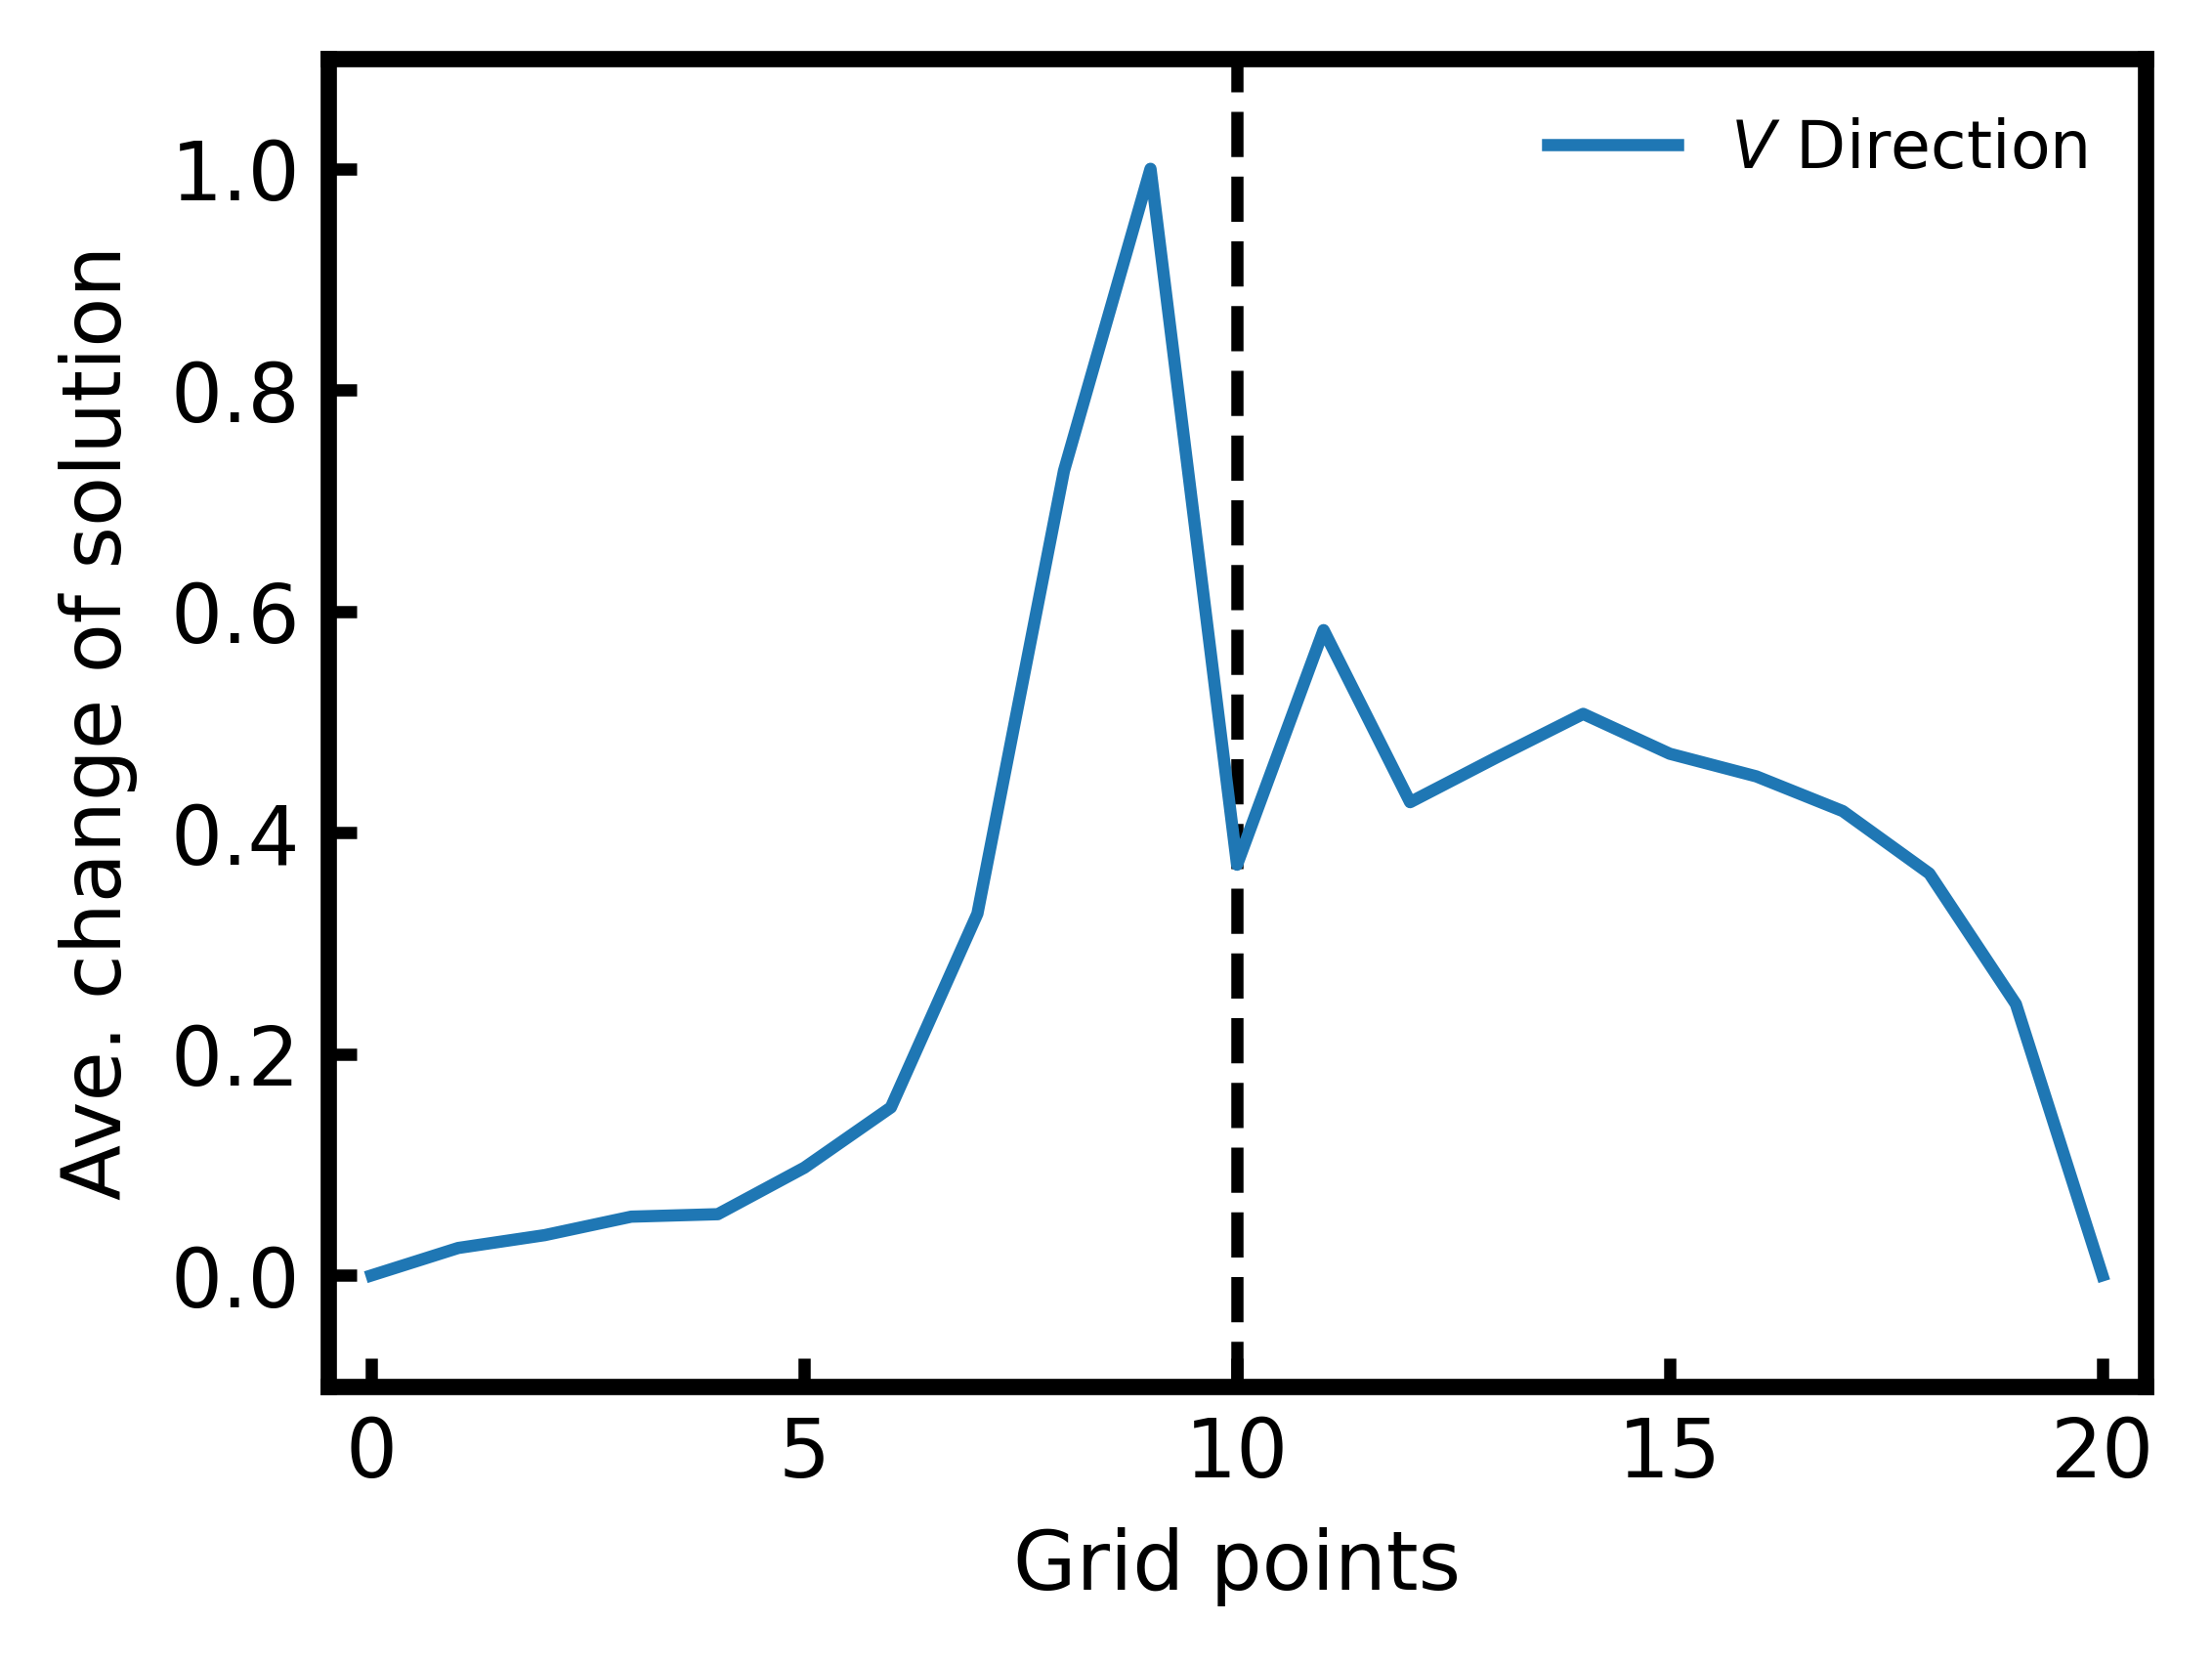

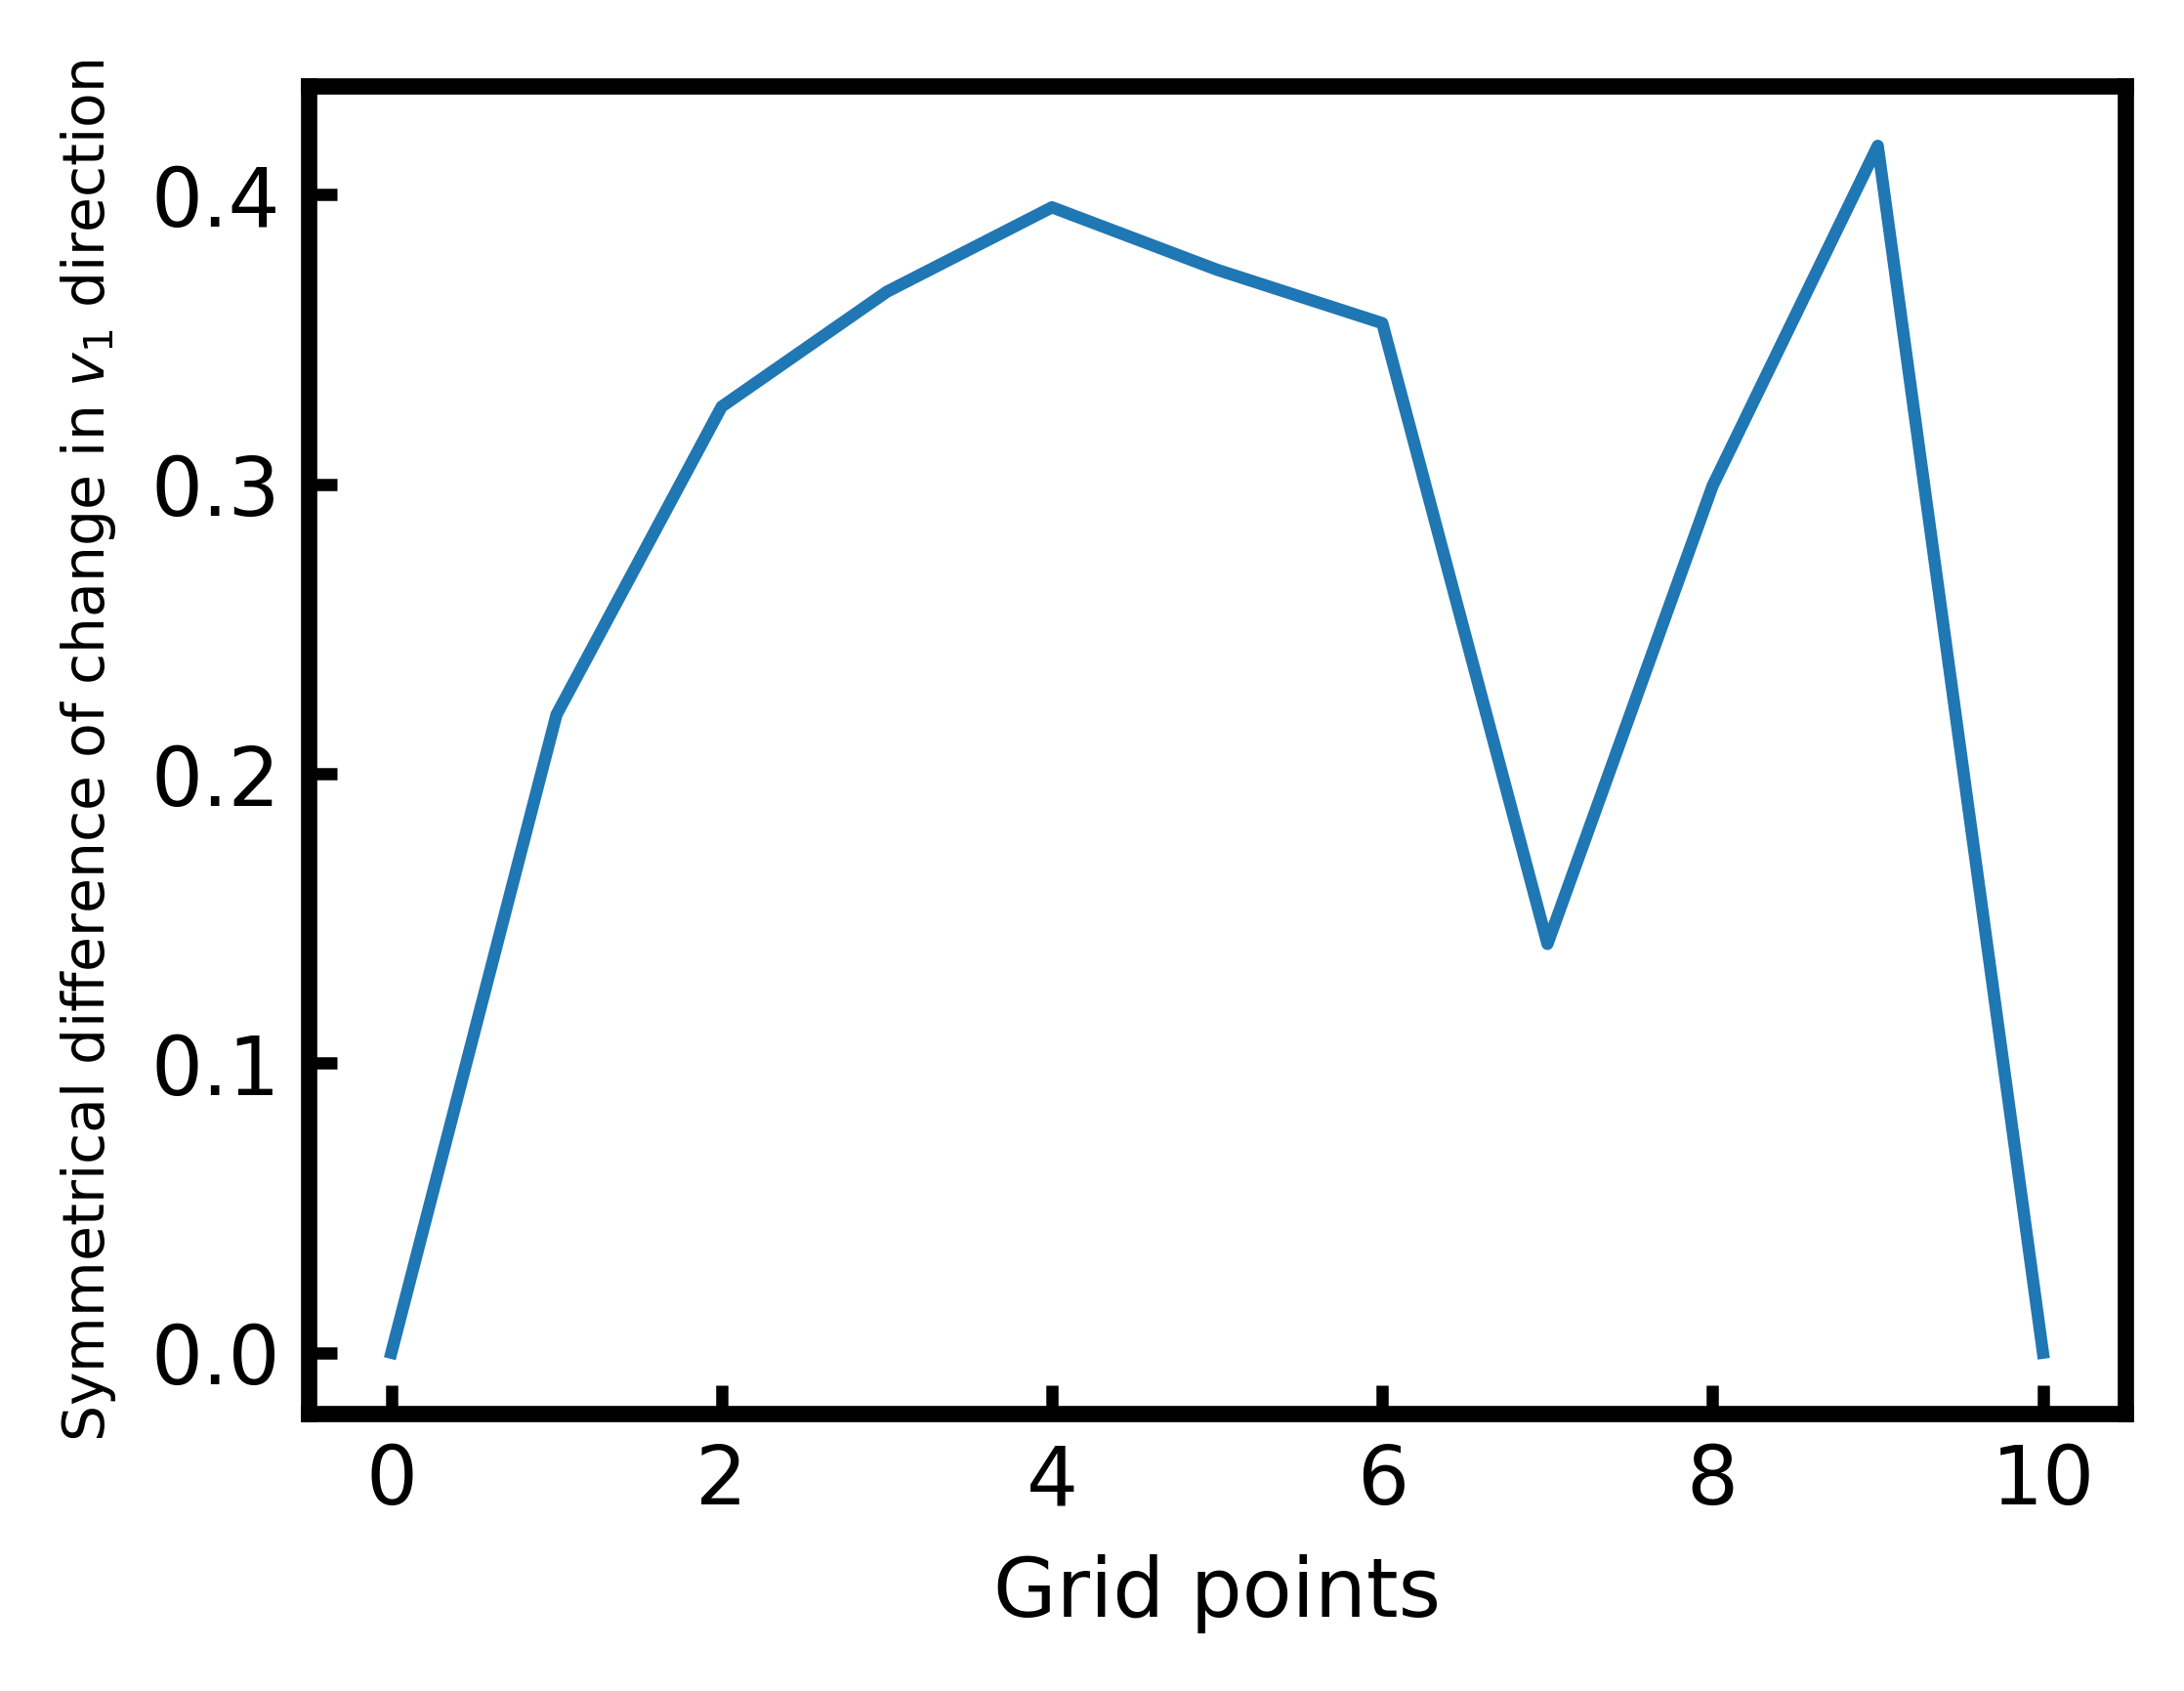

In [72]:
df = pd.read_csv('./DATA/6/' + str(365) + '.csv' , header=None)
data = df.to_numpy()
X = data[:,0]
Y = data[:,1]
t = np.zeros((len(data[1])-2 , 441))
value = np.zeros((len(t),21,21), dtype= float)
for i in range(len(data[1])-2):
    t[i] = data[:,i+2]
    for j in range(21):
        for k in range(21):
            value[i][j][k] = t[i][21*j+k]
value = (value - np.min(value)) / (np.max(value) - np.min(value))
if len(value) == 1:
    sequence = np.tile(value,(501,1,1)) 
else:
    sequence = value[:501]
    
prev_gray = sequence[0]
c1 = prev_gray[:,0][10]
c2 = prev_gray[0,:][10]
c3 = prev_gray[-1,:][10]
c4 = prev_gray[:,-1][10]
norm = np.sqrt((c1-c4)**2 + (c2-c3)**2)
d1 = (c1-c4) / norm
d2 = (c2-c3) / norm
for frame in range(len(sequence)):
    x_vec = []
    y_vec = []
    x_sub_vec = []
    y_sub_vec = []
    mat = sequence[frame]
    for grid in range(len(mat)):
        y = np.mean(mat[grid])
        x = np.mean(mat[:,grid])
        x_vec.append(x)
        y_vec.append(y)

    if frame == 450:
        mat_s = mat
        x_vec_s = x_vec
        y_vec_s = y_vec
        v = np.dot(y_vec , d1) - np.dot(x_vec, d2)       
        v = (v - np.min(v)) / (np.max(v) - np.min(v))
        sym = v[0:11] - np.flip(v[10:21])
        sym = np.abs(v[0:11] - np.flip(v[10:21]))

# # FIG 1 SEABORN HEATMAP
fig = plt.figure(figsize = [4,3], dpi = 600)
width = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(width)
plt.axis([-0.5,20.5,-0.5,20.5])
yticks = np.arange(21)
keptticks = yticks[::int(len(yticks)/4)]
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/4)] = keptticks
ax = sns.heatmap(mat_s, annot=False ,  xticklabels=yticks, yticklabels=yticks
                 ,vmin=0, vmax=1,cbar_kws={'label': 'Normalized solution'}) 
ax.arrow(10, 10.5, 2.304, 1.92,width=0.01,head_width=0.08 , color = 'white', fc='white')
ax.arrow(10, 10.5,-1.92, 2.304,width=0.01,head_width=0.08 , color = 'white', fc='white')
ax.text(11, 13, '$v_2$', color='white', fontsize=8)
ax.text(7, 12.5, '$v_1$', color='white', fontsize=8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()
# ax.set_xticks(xticks*ax.get_ylim()[1])

# # FIG 2) X,Y Direction
fig = plt.figure(figsize = [4,3], dpi = 600)
width = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(width)
    
tick_width = 1.5
plt.tick_params(direction = 'in', width = tick_width)

plt.axis([-0.5,20.5,-0.1,1.1])

plt.xticks([0, 5, 10,15, 20],['0', '5','10','15','20'],
           fontsize = 10)
plt.yticks(fontsize = 10)
###################################
plt.plot(np.arange(len(mat)), y_vec_s, label = 'Y Direction')
plt.plot(np.arange(len(mat)), x_vec_s, label = 'X Direction')

plt.legend(loc='upper right', fontsize = 8, frameon = False)
plt.ylabel("Ave. change of solution", fontsize=10)
plt.xlabel("Grid points", fontsize=10)
plt.show()

# FIG 3) V Direction
fig = plt.figure(figsize = [4,3], dpi = 600)
width = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(width)
    
tick_width = 1.5
plt.tick_params(direction = 'in', width = tick_width)

plt.axis([-0.5,20.5,-0.1,1.1])

plt.xticks([0, 5, 10,15, 20],['0', '5','10','15','20'],
           fontsize = 10)
plt.yticks(fontsize = 10)
###################################
plt.plot(np.arange(len(mat)), v, label = '$V$ Direction')

ax.vlines([10], 0, 1,  
          color ="black", linestyle='dashed',
          transform = ax.get_xaxis_transform()) 

plt.legend(loc='upper right', fontsize = 8, frameon = False)
plt.ylabel("Ave. change of solution", fontsize=10)
plt.xlabel("Grid points", fontsize=10)
plt.show()

# # ##FIG 4) SYMMETRY 
fig = plt.figure(figsize = [4,3], dpi = 600)
width = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(width)
tick_width = 1.5
plt.tick_params(direction = 'in', width = tick_width)
plt.xticks([0, 2, 4,6, 8,10],['0', '2','4','6','8','10'],
           fontsize = 10)
plt.yticks(fontsize = 10)
###################################
plt.plot(np.arange(len(sym)), sym)
plt.ylabel("Symmetrical difference of change in $v_1$ direction", fontsize=7)
plt.xlabel("Grid points", fontsize=10)
plt.show()

 # Symmetry of Motion Extract and Save feature

In [73]:
def sym(sequence):
    prev_gray = sequence[0]
    c1 = prev_gray[:,0][10]
    c2 = prev_gray[0,:][10]
    c3 = prev_gray[-1,:][10]
    c4 = prev_gray[:,-1][10]
    norm = np.sqrt((c1-c4)**2 + (c2-c3)**2)
    d1 = (c1-c4) / norm
    d2 = (c2-c3) / norm
    sym_max = 0
    sym_min = 0
    sym_amp = 0
    sym_mean = 0
    for frame in range(100, 400):  #len(sequence)
        x_vec = []
        y_vec = []
        x_sub_vec = []
        y_sub_vec = []
        mat = sequence[frame]
        for grid in range(len(mat)):
            x = np.mean(mat[grid])
            y = np.mean(mat[:,grid])
            x_vec.append(x)
            y_vec.append(y)
        v = np.dot(x_vec , d1) - np.dot(y_vec, d2)
        #Normalize
        v = (v - np.min(v)) / (np.max(v) - np.min(v))
        sym = np.abs(v[0:11] - np.flip(v[10:21]))
        sym_max += np.max(sym)
        sym_min += np.min(sym)
        sym_amp += (np.max(sym) - np.min(sym))
        sym_mean += np.mean(sym)
    length = 300
    sym_max = (sym_max/length)
    sym_min = (sym_min/length)
    sym_amp = (sym_amp/length)
    sym_mean = (sym_mean/length)
    ret = np.array([sym_max, sym_min, sym_amp, sym_mean])
    return ret

SYM = np.zeros((384*8, 4))
for eq in tqdm(range(8)):
    for iter in range(384):
        df = pd.read_csv ('./DATA/'+str(eq+1)+'/' + str(iter+1) + '.csv' , header=None)
        data = df.to_numpy()
        seq = process(data)
        ret = sym(seq)
        SYM[384*eq + iter] = ret 
    
# np.save('./FEATURES/SYM.npy', SYM)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [01:33<10:55, 93.60s/it]

 25%|██▌       | 2/8 [03:06<09:20, 93.49s/it]

 38%|███▊      | 3/8 [03:35<06:09, 73.92s/it]

 50%|█████     | 4/8 [04:03<04:00, 60.17s/it]

 62%|██████▎   | 5/8 [05:36<03:30, 70.24s/it]

 75%|███████▌  | 6/8 [07:10<02:34, 77.38s/it]

 88%|████████▊ | 7/8 [08:44<01:22, 82.36s/it]

100%|██████████| 8/8 [10:18<00:00, 77.32s/it]


# Coefficients

# C : Wave Propagation Speed 

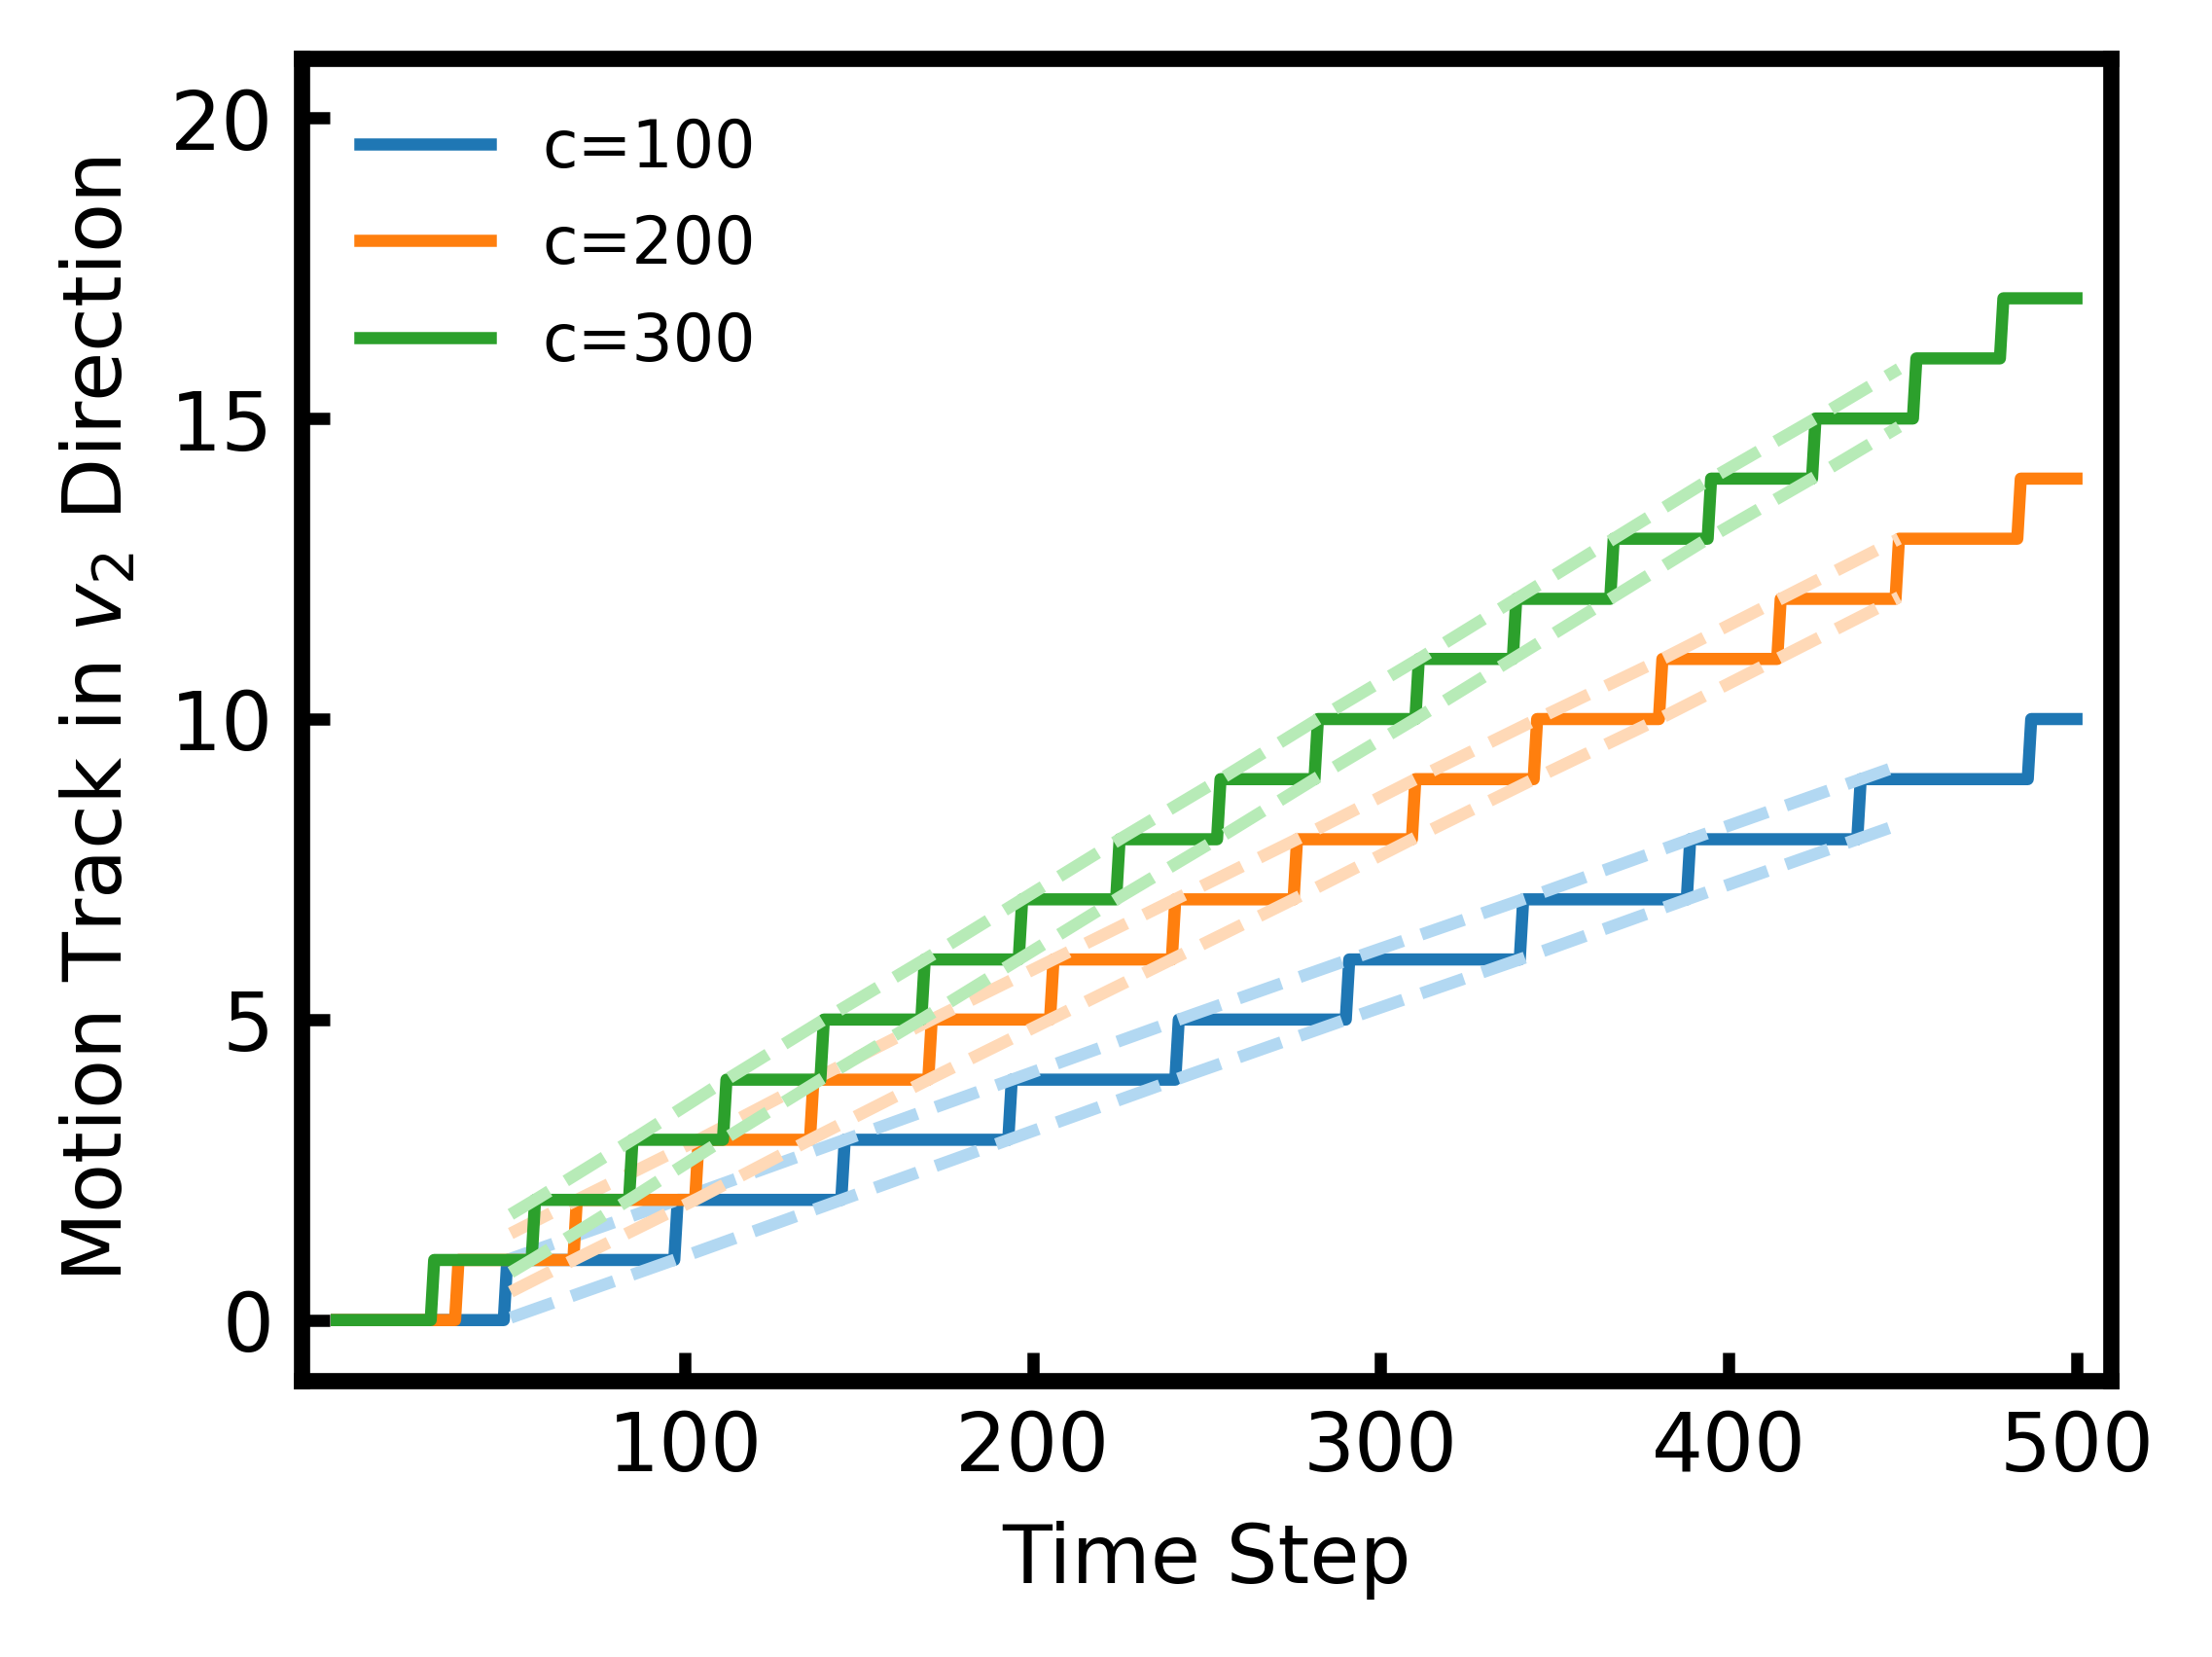

In [74]:
def get_argmax(sequence):
    prev_gray = sequence[0]
    c1 = prev_gray[:,0][10]
    c2 = prev_gray[0,:][10]
    c3 = prev_gray[-1,:][10]
    c4 = prev_gray[:,-1][10]
    norm = np.sqrt((c1-c4)**2 + (c2-c3)**2)
    d1 = (c1-c4) / norm
    d2 = (c2-c3) / norm
    argmax_vec = []
    for frame in range(len(sequence)):
        x_vec = []
        y_vec = []
        x_sub_vec = []
        y_sub_vec = []
        mat = sequence[frame]
        for grid in range(len(mat)):
            x = np.mean(mat[grid])
            y = np.mean(mat[:,grid])
            x_vec.append(x)
            y_vec.append(y)

        v2 = np.dot(y_vec , d1) + np.dot(x_vec, d2)       
        v2 = (v2 - np.min(v2)) / (np.max(v2) - np.min(v2))
        vec = np.abs(np.diff(v2))
        argmax = np.argmax(vec[0:-1])
        argmax_vec.append(argmax)
    return argmax_vec
    
def envelopes(argmax_vec):
    s = np.array(argmax_vec)
    u_x = []
    u_y = []
    l_x = []
    l_y = []
    count_u = 0
    count_l = 0
    check_first_u = 0
    check_first_l = 0
    #Detect peaks and troughs and mark their location in u_x,u_y,l_x,l_y respectively.
    for k in range(1,len(s)-1):
        if (s[k+1]-s[k]>1) or (s[k+1]-s[k]<-1):
            print(k)
            break
        if (np.sign(s[k]-s[k-1])==1) and (np.sign(s[k]-s[k+1])== 0):
            u_x.append(k)
            u_y.append(s[k])
            last_s_u = s[k]
            count_u += 1
            if check_first_u == 0:
                first_s_u = s[k]
                check_first_u = 1
        if (np.sign(s[k]-s[k-1])==0) and ((np.sign(s[k]-s[k+1]))==-1):
            l_x.append(k)
            l_y.append(s[k])
            last_s_l = s[k]
            count_l += 1
            if check_first_l == 0:
                first_s_l = s[k]
                check_first_l = 1

    u2_x = []
    u2_y = []
    l2_x = []
    l2_y = []
    count_u2 = 0
    count_l2 = 0
    check_first_u2 = 0
    check_first_l2 = 0
    #Detect peaks and troughs and mark their location in u_x,u_y,l_x,l_y respectively.
    for k in range(1,len(s)-1):
        if (np.sign(s[k]-s[k-1])==0) and (np.sign(s[k]-s[k+1])== 1):
            u2_x.append(k)
            u2_y.append(s[k])
            last_s_u2 = s[k]
            count_u2 += 1
            if check_first_u2 == 0:
                first_s_u2 = s[k]
                check_first_u2 = 1

        if (np.sign(s[k]-s[k-1])==-1) and ((np.sign(s[k]-s[k+1]))==0):
            l2_x.append(k)
            l2_y.append(s[k])
            last_s_l2 = s[k]
            count_l2 += 1
            if check_first_l2 == 0:
                first_s_l2 = s[k]
                check_first_l2 = 1

    if len(u_x)>len(u2_x):
        slope = np.mean(1/np.diff(u_x))
    else:
        slope = np.mean(1/np.diff(u2_x))

    u_p = interp1d(u_x,u_y,bounds_error = False, fill_value=0.0)
    l_p = interp1d(l_x,l_y,bounds_error = False, fill_value=0.0)
    q_u = np.zeros(s.shape)
    q_l = np.zeros(s.shape)
    amp = np.zeros(s.shape)
    for k in range(0,len(s)):
        q_u[k] = u_p(k)
        q_l[k] = l_p(k)
        amp[k] = q_u[k] - q_l[k]
    return q_u, q_l, amp , slope

s_list =[]
u=[]
l=[]
amp_list=[]
slopes=[]
for i in range(3):
    df = pd.read_csv ('./DATA/5/' + str(1+128*i) + '.csv' , header=None)
    data = df.to_numpy()
    sequence = process(data)
    argmax_vec = get_argmax(sequence)
    q_u, q_l, amp , slope = envelopes(argmax_vec)
    s = np.array(argmax_vec)
    s_list.append(s)
    u.append(q_u)
    l.append(q_l)
    amp_list.append(amp)
    slopes.append(slope)
    

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig = plt.figure(figsize = [4,3], dpi = 600)
width = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(width)
    
tick_width = 1.5
plt.tick_params(direction = 'in', width = tick_width)

plt.axis([-10,510,-1,21])

plt.xticks([100, 200,300, 400,500],['100','200','300','400','500'],
           fontsize = 10)
plt.yticks(fontsize = 10)
###################################
for i in range(3):
    plt.plot(s_list[i] , color='C'+str(i), label='c='+str(100+100*i))
    plt.plot(np.arange(50,450), u[i][50:450], color=lighten_color('C'+str(i), 0.3) , linestyle='dashed')
    plt.plot(np.arange(50,450), l[i][50:450], color=lighten_color('C'+str(i), 0.3), linestyle='dashed')
    
plt.ylabel("Motion Track in $v_2$ Direction")
plt.xlabel("Time Step")
plt.legend(loc='upper left', fontsize = 8, frameon = False)
plt.show()